In [1]:
import cv2
import mediapipe as mp
import os
import cv2
import numpy as np
import dlib
import pandas as pd

# 面部检测算法

## mediapipe

### 面部关键点

In [48]:
# 读取图像
me_sample = 'angry_yangmi20230728_116_8.42_8.61_8.89'
me_crop_path = r'E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\pics_selected\Micro'
image = cv2.imread(os.path.join(me_crop_path, me_sample, 'onset.png'))

In [6]:
# 初始化Mediapipe的Face Mesh模块
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

In [7]:
# 定义绘制面部关键点和轮廓的函数
def draw_face_landmarks(image, face_landmarks):
    # 绘制面部轮廓
    mp_drawing.draw_landmarks(
        image=image,
        landmark_list=face_landmarks,
        connections=mp_face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style()
    )

    # 绘制面部关键点
    mp_drawing.draw_landmarks(
        image=image,
        landmark_list=face_landmarks,
        connections=mp_face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style()
    )

In [13]:
# 检查图像是否读取成功
if image is None:
    print("Error: Unable to read the image.")
else:
    # 将BGR图像转换为RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    with mp_face_mesh.FaceMesh(
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    ) as face_mesh:
        # 处理图像并检测面部关键点
        results = face_mesh.process(image_rgb)

        # 如果检测到面部关键点
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                draw_face_landmarks(image, face_landmarks)

        # 显示结果
        cv2.imwrite('Face Mesh onset.png', image)

### 面部区域裁剪

In [24]:
def get_face_roi(src_img, img_save_path):
    # 获取面部关键点
    results = face_mesh.process(cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks:
        landmarks = results.multi_face_landmarks[0].landmark

        # 计算面部区域的边界框
        x_min, x_max = float('inf'), float('-inf')
        y_min, y_max = float('inf'), float('-inf')
        for landmark in landmarks:
            x, y = int(landmark.x * src_img.shape[1]), int(landmark.y * src_img.shape[0])
            if x < x_min:
                x_min = x
            if x > x_max:
                x_max = x
            if y < y_min:
                y_min = y
            if y > y_max:
                y_max = y

        # 裁剪面部区域
        face_roi = src_img[y_min:y_max, x_min:x_max]

        # 保存裁剪后的面部区域
        cv2.imwrite(img_save_path, face_roi)
        print('save img success!')

# 初始化面部关键点检测器
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

# 读取图片
onset_image = cv2.imread(os.path.join(me_crop_path, me_sample, 'onset.png'))
apex_image = cv2.imread(os.path.join(me_crop_path, me_sample, 'apex.png'))

onset_cropped = 'mediapipe_onset_cropped.jpg'
apex_cropped = 'mediapipe_apex_cropped.jpg'

get_face_roi(onset_image, onset_cropped)
get_face_roi(apex_image, apex_cropped)

save img success!
save img success!


## Dlib

In [19]:
predictor_path = r"E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Data_preprocess\shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector() # face_detector
predictor = dlib.shape_predictor(predictor_path) # facial landmark predictor

In [20]:
def faceDetector(img):
    gray = cv2.cvtColor(np.array(img),cv2.COLOR_BGR2GRAY)
    # 检测人脸并进行关键点检测
    faces = detector(gray)
    for face in faces:
        landmarks = predictor(gray, face)  
        return face, landmarks

In [21]:
def draw_face(img, landmarks, img_save_patn):
    # 在图像上标记关键点位置和序号
    for i, point in enumerate(landmarks.parts()):
        x, y = point.x, point.y
#         cv2.putText(img, str(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1, cv2.LINE_AA)
        cv2.circle(img, (x, y), 1, (0, 0, 255), -1)
    # 保存标记后的图像
    cv2.imwrite(img_save_patn, img)
    print('save img success!')

In [22]:
onset_image = cv2.imread(os.path.join(me_crop_path, me_sample, 'onset.png'))
apex_image = cv2.imread(os.path.join(me_crop_path, me_sample, 'apex.png'))

onpex_landmarks = 'dlib_onset_image.jpg'
apex_landmarks = 'dlib_apex_image.jpg'

face, landmarks = faceDetector(onset_image)
draw_face(onset_image, landmarks, onpex_landmarks)
face, landmarks = faceDetector(apex_image)
draw_face(apex_image, landmarks, apex_landmarks)

save img success!
save img success!


## 阿里云

### 面部关键点

In [12]:
import re
import time
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob
from alibabacloud_facebody20191230.client import Client
from alibabacloud_facebody20191230.models import DetectFaceAdvanceRequest
from alibabacloud_tea_openapi.models import Config
from alibabacloud_tea_util.models import RuntimeOptions
from PIL import Image

In [30]:
def face_reg_alibabacloud(pic_path):
    config = Config(
    # 创建AccessKey ID和AccessKey Secret，请参考https://help.aliyun.com/document_detail/175144.html
    # 从环境变量读取配置的AccessKey ID和AccessKey Secret。运行代码示例前必须先配置环境变量。
    access_key_id=os.environ.get('ALIBABA_CLOUD_ACCESS_KEY_ID'),
    access_key_secret=os.environ.get('ALIBABA_CLOUD_ACCESS_KEY_SECRET'),
    # 访问的域名
    endpoint='facebody.cn-shanghai.aliyuncs.com',
    # 访问的域名对应的region
    region_id='cn-shanghai')

    detect_face_request = DetectFaceAdvanceRequest()

    # 文件在本地
    stream = open(pic_path, 'rb')
    detect_face_request.image_urlobject = stream
    detect_face_request.landmark = True
    detect_face_request.quality = True
    detect_face_request.pose = False
    detect_face_request.max_face_number = 1

    runtime = RuntimeOptions()

    # 初始化Client
    client = Client(config)
    response = client.detect_face_advance(detect_face_request, runtime)
    # 获取识别结果
    result = dict()
    result['body'] = response.body.to_map()
    face_info = result['body'].get('Data')
    # print(face_info)
    # print(face_info.get('FaceRectangles'))
    # 返回人脸矩形框，分别是[left, top, width, height]
    FaceRectangles = face_info.get('FaceRectangles')
    # 返回人脸特征点定位结果，每个人脸返回一组特征点位置，表示方式为（x0, y0, x1, y1, ……），如有多个人脸，则依次顺延，返回定位浮点数。
    # LandmarkCount人脸特征点数目，目前固定为105点。依次为：眉毛24点，眼睛32点，鼻子6点，嘴巴34点，外轮廓9点
    Landmarks = face_info.get('Landmarks')

    time.sleep(1)

    return FaceRectangles, Landmarks

In [31]:
def draw_rectangle_and_landmarks(img_path, img_save_patn):
    image = cv2.imread(img_path)
    # 计算面部区域的边界框
    x_min, x_max = float('inf'), float('-inf')
    y_min, y_max = float('inf'), float('-inf')
    F, L = face_reg_alibabacloud(img_path)
    # 将表示方式转换为坐标对列表
    landmarks = [(int(L[i]), int(L[i + 1])) for i in range(0, len(L), 2)]
    
    for landmark in landmarks:
        x, y = int(landmark[0]), int(landmark[1])
        cv2.circle(image, (x, y), 2, (0, 255, 0), -1)
    
    # 绘制面部关键点索引
    for idx, landmark in enumerate(landmarks):
        x, y = int(landmark[0]), int(landmark[1])
        cv2.circle(image, (x, y), 2, (0, 255, 0), -1)
        cv2.putText(image, str(idx + 1), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
        
        
    cv2.imwrite(img_save_patn, image)
    print('save img success!')

### 面部区域裁剪

In [44]:

FaceRectangles, Landmarks = face_reg_alibabacloud(os.path.join(me_crop_path, me_sample, 'onset.png'))
onset_image = cv2.imread(os.path.join(me_crop_path, me_sample, 'onset.png'))

# print('shape:', onset_image.shape)
# print('FaceRectangles[0]:', FaceRectangles[0])
# print('FaceRectangles[1]:', FaceRectangles[1])
# print('FaceRectangles[2]:', FaceRectangles[2])
# print('FaceRectangles[3]:', FaceRectangles[3])

# cv2.rectangle(onset_image, (FaceRectangles[0], FaceRectangles[1]), (FaceRectangles[0]+FaceRectangles[2], FaceRectangles[1]+FaceRectangles[3]), (0, 255, 0), 2)

# 裁剪面部区域
face_roi = onset_image[FaceRectangles[1]: FaceRectangles[1]+FaceRectangles[3],
                      FaceRectangles[0]: FaceRectangles[0]+FaceRectangles[2]]


cv2.imwrite(img_save_patn, face_roi)
print('save img success!')

shape: (1088, 2048, 3)
FaceRectangles[0]: 764
FaceRectangles[1]: 353
FaceRectangles[2]: 545
FaceRectangles[3]: 647


In [47]:
def get_face_roi(src_img, img_save_path):
    FaceRectangles, Landmarks = face_reg_alibabacloud(os.path.join(me_crop_path, me_sample, src_img))
    image = cv2.imread(os.path.join(me_crop_path, me_sample, src_img))

    # 裁剪面部区域
    face_roi = image[FaceRectangles[1]: FaceRectangles[1]+FaceRectangles[3],
                     FaceRectangles[0]: FaceRectangles[0]+FaceRectangles[2]]


    cv2.imwrite(img_save_path, face_roi)
    print('save img success!')
        
get_face_roi('onset.png', 'aliyun_onset_cropped.jpg')        
get_face_roi('apex.png', 'aliyun_apex_cropped.jpg') 

save img success!
save img success!


# 检查样本标注excel与样本视频是否一致

In [210]:
annotator = 'combined'

# Excel文件路径  
annotation_file = 'coding_file_' + annotator + '.xlsx'
# 读取Excel文件  
df = pd.read_excel(annotation_file)

# 创建新的列 'video_name'
df['video_name'] = df.apply(
    lambda row: f"video_{row['Estimated Emotion']}_{row['Subject']}{row['Filename'].split('_')[-1][:8]}_{row['Marker']}_{row['OnsetTime']:.2f}_{row['ApexTime']:.2f}_{row['OffsetTime']:.2f}.avi", 
    axis=1
)
df['video_name']

0      video_angry_fengdengfang20230802_146_24.33_24....
1      video_angry_wangxiaomin20230718_146_12.09_12.6...
2      video_angry_wangxiaomin20230718_146_3.32_3.60_...
3      video_angry_wangxiaomin20230718_146_36.31_36.8...
4      video_angry_wangxiaomin20230718_146_37.70_38.2...
                             ...                        
939    video_happy_yansen20230731_138_26.67_27.12_27....
940    video_happy_zhangdi20230721_138_44.83_45.31_45...
941    video_happy_zhengwansheng20230718_138_24.93_25...
942    video_happy_zhengwansheng20230718_138_42.17_42...
943    video_happy_zhengwansheng20230718_138_55.92_56...
Name: video_name, Length: 944, dtype: object

- 微表情

In [211]:
exp_type = 'Micro'

df_ME = df[df['Macro/Micro'] == exp_type]

# excel中的样本列表
ME_video_name_list = df_ME['video_name'].tolist()
print('excel中样本数：', len(ME_video_name_list))

# 文件夹中的样本列表
ME_avi_files = [f for f in os.listdir(os.path.join('0.videos', annotator, exp_type)) if f.endswith('.avi')] 
ME_avi_files_cleaned = [file.rsplit('_', 1)[0] + '.avi' for file in ME_avi_files]
print('文件夹中样本数：', len(ME_avi_files_cleaned))

# 将列表转换为集合
set_ME_video_name_list = set(ME_video_name_list)
set_ME_avi_files_cleaned = set(ME_avi_files_cleaned)

# 找出excel中存在但文件夹中不存在的元素
only_in_video_name_list_ME = set_ME_video_name_list - set_ME_avi_files_cleaned

# 找出文件夹中存在但excel中不存在的元素
only_in_ME_avi_files_cleaned = set_ME_avi_files_cleaned - set_ME_video_name_list

# 打印结果
print("excel中存在但文件夹中不存在的样本:")
for element in only_in_video_name_list_ME:
    print(element)

print("文件夹中存在但excel中不存在的样本:")
for element in only_in_ME_avi_files_cleaned:
    print(element)

excel中样本数： 299
文件夹中样本数： 299
excel中存在但文件夹中不存在的样本:
文件夹中存在但excel中不存在的样本:


- 宏表情

In [212]:
exp_type = 'Macro'

df_MaE = df[df['Macro/Micro'] == exp_type]

# excel中的样本列表
MaE_video_name_list = df_MaE['video_name'].tolist()
print('excel中样本数：', len(MaE_video_name_list))

# 文件夹中的样本列表
MaE_avi_files = [f for f in os.listdir(os.path.join('0.videos', annotator, exp_type)) if f.endswith('.avi')] 
MaE_avi_files_cleaned = [file.rsplit('_', 1)[0] + '.avi' for file in MaE_avi_files]
print('文件夹中样本数：', len(MaE_avi_files_cleaned))

# 将列表转换为集合
set_MaE_video_name_list = set(MaE_video_name_list)
set_MaE_avi_files_cleaned = set(MaE_avi_files_cleaned)

# 找出excel中存在但文件夹中不存在的元素
only_in_video_name_list_MaE = set_MaE_video_name_list - set_MaE_avi_files_cleaned

# 找出文件夹中存在但excel中不存在的元素
only_in_MaE_avi_files_cleaned = set_MaE_avi_files_cleaned - set_MaE_video_name_list

# 打印结果
print("excel中存在但文件夹中不存在的样本:")
for element in only_in_video_name_list_MaE:
    print(element)

print("文件夹中存在但excel中不存在的样本:")
for element in only_in_MaE_avi_files_cleaned:
    print(element)

excel中样本数： 645
文件夹中样本数： 645
excel中存在但文件夹中不存在的样本:
文件夹中存在但excel中不存在的样本:


# 获取关键帧

- 获取0.videos中的视频文件的起始帧和峰值帧，存入1.pics_selected

## 根据视频名称、起始帧与峰值帧距离dif，存储对应的起始帧和峰值帧

- 在峰值帧=结束帧时，有的视频的实际帧数会小于根据起始帧和峰值帧最后一位数字得到的dif

In [16]:
# 根据excel中每条样本信息，查找对应的avi视频样本
def find_video_by_prefix(prefix, avi_files):
    matched_videos = [video for video in avi_files if prefix in video]
    if matched_videos:  
        return matched_videos 
    else:  
        print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!no matched!')
        return None

In [76]:
import imageio

def save_frames(exp_type, matched_video, dif, output_dir):
    # 打开视频文件
    video_path = os.path.join(r'E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\0.videos\combined', 
                              exp_type, matched_video)
    print('video_path:', video_path)
    # 读取视频文件
    cap = cv2.VideoCapture(video_path)
    
    # 检查视频是否成功打开
    if not cap.isOpened():
        print("Error: Could not open video.")
        return
    
    # 获取视频的总帧数
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # 读取第 1 帧
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    ret, frame1 = cap.read()
    cv2.imwrite(f"{output_dir}/onset.png", frame1)
    
    # 读取第dif帧，如果指定帧超出总帧数，取最后一帧
    if dif >= total_frames:
        print(f'dif: {dif} >= total_frames: {total_frames}')
        dif = total_frames - 10
        
    print('final dif:', dif)  
    # 读取第 dif 帧
    cap.set(cv2.CAP_PROP_POS_FRAMES, dif)
    ret, frame2 = cap.read()
    if ret:
        cv2.imwrite(f"{output_dir}/apex.png", frame2)
    else:
        print(f"Error: Could not read the frame at dif position *************************************************")
    
   # 释放视频文件
    cap.release() 
    
    print('-------------------------------------------------------------------------')

### 遍历微表情每行数据

In [77]:
exp_type = 'Micro'

for index, row in df_ME.iterrows():
    file_name = 'video_' + row['Filename'].split('_')[0] + '_' + row['Filename'].split('_')[3] + row['Filename'].split('_')[4].split('.')[0] + '_' + row['Filename'].split('_')[2] + '_' + "{:.2f}".format(row['OnsetTime']) + '_' + "{:.2f}".format(row['ApexTime']) + '_' + "{:.2f}".format(row['OffsetTime'])
    # print('file_name:', file_name)
    matched_video = find_video_by_prefix(file_name, ME_avi_files)[0]
    print('matched_video:', matched_video)
    
    output_dir = os.path.join('1.pics_selected',  exp_type, '_'.join(file_name.split('_')[1:]))
    os.makedirs(output_dir, exist_ok = True)
    print(output_dir)
    
    save_frames(exp_type, matched_video, row['dif'], output_dir)  

matched_video: video_happy_yangmi20230728_120_35.28_35.53_35.75_143.avi
1.pics_selected\Micro\happy_yangmi20230728_120_35.28_35.53_35.75
video_path: E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\0.videos\combined\Micro\video_happy_yangmi20230728_120_35.28_35.53_35.75_143.avi
final dif: 26
-------------------------------------------------------------------------
matched_video: video_happy_zhaoshaohua20230801_120_48.14_48.33_48.60_147.avi
1.pics_selected\Micro\happy_zhaoshaohua20230801_120_48.14_48.33_48.60
video_path: E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\0.videos\combined\Micro\video_happy_zhaoshaohua20230801_120_48.14_48.33_48.60_147.avi
final dif: 29
-------------------------------------------------------------------------
matched_video: video_happy_zhengwansheng20230718_129_49.60_49.85_50.10.avi
1.pics_selected\Micro\happy_zhengwansheng20230718_129_49.60_49.85_50.10
video_path: E:\10.Doctoral materials\0.Micro-expression\1.

final dif: 28
-------------------------------------------------------------------------
matched_video: video_angry_yangmi20230728_116_51.50_51.69_51.97_142.avi
1.pics_selected\Micro\angry_yangmi20230728_116_51.50_51.69_51.97
video_path: E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\0.videos\combined\Micro\video_angry_yangmi20230728_116_51.50_51.69_51.97_142.avi
final dif: 27
-------------------------------------------------------------------------
matched_video: video_angry_zhaoshaohua20230801_116_25.45_25.64_25.91_148.avi
1.pics_selected\Micro\angry_zhaoshaohua20230801_116_25.45_25.64_25.91
video_path: E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\0.videos\combined\Micro\video_angry_zhaoshaohua20230801_116_25.45_25.64_25.91_148.avi
final dif: 29
-------------------------------------------------------------------------
matched_video: video_angry_wangziheng20230727_125_53.78_53.96_54.23_146.avi
1.pics_selected\Micro\angry_wangziheng202

-------------------------------------------------------------------------
matched_video: video_fear_yangmi20230728_121_7.49_7.74_7.74_141.avi
1.pics_selected\Micro\fear_yangmi20230728_121_7.49_7.74_7.74
video_path: E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\0.videos\combined\Micro\video_fear_yangmi20230728_121_7.49_7.74_7.74_141.avi
dif: 36 >= total_frames: 36
final dif: 26
Error: Could not read the frame at dif position *************************************************
-------------------------------------------------------------------------
matched_video: video_fear_yangmi20230728_121_14.24_14.41_14.74_141.avi
1.pics_selected\Micro\fear_yangmi20230728_121_14.24_14.41_14.74
video_path: E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\0.videos\combined\Micro\video_fear_yangmi20230728_121_14.24_14.41_14.74_141.avi
final dif: 25
-------------------------------------------------------------------------
matched_video: video_fear_yangmi202

final dif: 42
-------------------------------------------------------------------------
matched_video: video_sad_zhaoshaohua20230801_101_22.96_23.24_23.42_142.avi
1.pics_selected\Micro\sad_zhaoshaohua20230801_101_22.96_23.24_23.42
video_path: E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\0.videos\combined\Micro\video_sad_zhaoshaohua20230801_101_22.96_23.24_23.42_142.avi
final dif: 41
-------------------------------------------------------------------------
matched_video: video_sad_zhaoshaohua20230801_101_25.05_25.55_25.55_142.avi
1.pics_selected\Micro\sad_zhaoshaohua20230801_101_25.05_25.55_25.55
video_path: E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\0.videos\combined\Micro\video_sad_zhaoshaohua20230801_101_25.05_25.55_25.55_142.avi
dif: 72 >= total_frames: 72
final dif: 62
-------------------------------------------------------------------------
matched_video: video_sad_zhengwansheng20230718_101_48.15_48.40_48.40_150.avi
1.pics_se

-------------------------------------------------------------------------
matched_video: video_disgust_zhengwansheng20230718_112_53.69_54.05_54.05_146.avi
1.pics_selected\Micro\disgust_zhengwansheng20230718_112_53.69_54.05_54.05
video_path: E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\0.videos\combined\Micro\video_disgust_zhengwansheng20230718_112_53.69_54.05_54.05_146.avi
dif: 54 >= total_frames: 53
final dif: 43
-------------------------------------------------------------------------
matched_video: video_disgust_yangmi20230728_102_2.11_2.21_2.39_144.avi
1.pics_selected\Micro\disgust_yangmi20230728_102_2.11_2.21_2.39
video_path: E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\0.videos\combined\Micro\video_disgust_yangmi20230728_102_2.11_2.21_2.39_144.avi
final dif: 16
-------------------------------------------------------------------------
matched_video: video_disgust_yangmi20230728_102_9.90_10.28_10.37_144.avi
1.pics_selected\Micro

dif: 38 >= total_frames: 37
final dif: 27
-------------------------------------------------------------------------
matched_video: video_happy_wangziheng20230727_123_29.25_29.65_29.75_145.avi
1.pics_selected\Micro\happy_wangziheng20230727_123_29.25_29.65_29.75
video_path: E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\0.videos\combined\Micro\video_happy_wangziheng20230727_123_29.25_29.65_29.75_145.avi
final dif: 59
-------------------------------------------------------------------------
matched_video: video_happy_yansen20230731_123_4.95_5.20_5.20_150.avi
1.pics_selected\Micro\happy_yansen20230731_123_4.95_5.20_5.20
video_path: E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\0.videos\combined\Micro\video_happy_yansen20230731_123_4.95_5.20_5.20_150.avi
dif: 39 >= total_frames: 37
final dif: 27
-------------------------------------------------------------------------
matched_video: video_happy_zhaolei20230803_123_9.48_9.72_9.72_145.avi
1.p

final dif: 28
-------------------------------------------------------------------------
matched_video: video_disgust_wangzishan20230717_110_20.28_20.77_20.77_145.avi
1.pics_selected\Micro\disgust_wangzishan20230717_110_20.28_20.77_20.77
video_path: E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\0.videos\combined\Micro\video_disgust_wangzishan20230717_110_20.28_20.77_20.77_145.avi
dif: 72 >= total_frames: 71
final dif: 61
-------------------------------------------------------------------------
matched_video: video_disgust_xietao20230803_110_43.30_43.55_43.55_98.avi
1.pics_selected\Micro\disgust_xietao20230803_110_43.30_43.55_43.55
video_path: E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\0.videos\combined\Micro\video_disgust_xietao20230803_110_43.30_43.55_43.55_98.avi
dif: 25 >= total_frames: 25
final dif: 15
-------------------------------------------------------------------------
matched_video: video_disgust_yangmi20230728_110_42.45_

-------------------------------------------------------------------------
matched_video: video_sad_zhaolei20230803_127_10.66_10.84_10.93_145.avi
1.pics_selected\Micro\sad_zhaolei20230803_127_10.66_10.84_10.93
video_path: E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\0.videos\combined\Micro\video_sad_zhaolei20230803_127_10.66_10.84_10.93_145.avi
final dif: 27
-------------------------------------------------------------------------
matched_video: video_sad_zhaolei20230803_127_24.89_25.14_25.14_145.avi
1.pics_selected\Micro\sad_zhaolei20230803_127_24.89_25.14_25.14
video_path: E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\0.videos\combined\Micro\video_sad_zhaolei20230803_127_24.89_25.14_25.14_145.avi
dif: 37 >= total_frames: 37
final dif: 27
-------------------------------------------------------------------------
matched_video: video_sad_wangxiaomin20230718_136_19.44_19.76_20.00_150.avi
1.pics_selected\Micro\sad_wangxiaomin20230718_136

-------------------------------------------------------------------------
matched_video: video_disgust_yangmi20230728_110_46.45_46.65_46.85_142.avi
1.pics_selected\Micro\disgust_yangmi20230728_110_46.45_46.65_46.85
video_path: E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\0.videos\combined\Micro\video_disgust_yangmi20230728_110_46.45_46.65_46.85_142.avi
dif: 218 >= total_frames: 57
final dif: 47
-------------------------------------------------------------------------
matched_video: video_disgust_zhaoshaohua20230801_110_2.54_2.66_2.85_148.avi
1.pics_selected\Micro\disgust_zhaoshaohua20230801_110_2.54_2.66_2.85
video_path: E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\0.videos\combined\Micro\video_disgust_zhaoshaohua20230801_110_2.54_2.66_2.85_148.avi
dif: 132 >= total_frames: 46
final dif: 36
-------------------------------------------------------------------------
matched_video: video_disgust_zhaoshaohua20230801_110_3.85_4.02_4.20_14

dif: 135 >= total_frames: 42
final dif: 32
-------------------------------------------------------------------------
matched_video: video_surprise_zhaoshaohua20230801_117_25.74_25.89_26.02_147.avi
1.pics_selected\Micro\surprise_zhaoshaohua20230801_117_25.74_25.89_26.02
video_path: E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\0.videos\combined\Micro\video_surprise_zhaoshaohua20230801_117_25.74_25.89_26.02_147.avi
dif: 152 >= total_frames: 41
final dif: 31
-------------------------------------------------------------------------
matched_video: video_surprise_zhaoshaohua20230801_117_26.02_26.20_26.50_147.avi
1.pics_selected\Micro\surprise_zhaoshaohua20230801_117_26.02_26.20_26.50
video_path: E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\0.videos\combined\Micro\video_surprise_zhaoshaohua20230801_117_26.02_26.20_26.50_147.avi
dif: 175 >= total_frames: 71
final dif: 61
-----------------------------------------------------------------------

dif: 203 >= total_frames: 63
final dif: 53
-------------------------------------------------------------------------
matched_video: video_angry_yangmi20230728_146_28.43_28.60_28.60_139.avi
1.pics_selected\Micro\angry_yangmi20230728_146_28.43_28.60_28.60
video_path: E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\0.videos\combined\Micro\video_angry_yangmi20230728_146_28.43_28.60_28.60_139.avi
dif: 171 >= total_frames: 24
final dif: 14
-------------------------------------------------------------------------
matched_video: video_angry_yangmi20230728_146_41.00_41.18_41.40_139.avi
1.pics_selected\Micro\angry_yangmi20230728_146_41.00_41.18_41.40
video_path: E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\0.videos\combined\Micro\video_angry_yangmi20230728_146_41.00_41.18_41.40_139.avi
dif: 186 >= total_frames: 56
final dif: 46
-------------------------------------------------------------------------
matched_video: video_angry_wangziheng20230727

-------------------------------------------------------------------------
matched_video: video_angry_wangziheng20230727_142_25.16_25.36_25.54_144.avi
1.pics_selected\Micro\angry_wangziheng20230727_142_25.16_25.36_25.54
video_path: E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\0.videos\combined\Micro\video_angry_wangziheng20230727_142_25.16_25.36_25.54_144.avi
dif: 195 >= total_frames: 55
final dif: 45
-------------------------------------------------------------------------
matched_video: video_angry_zhaoshaohua20230801_142_11.34_11.43_11.61_148.avi
1.pics_selected\Micro\angry_zhaoshaohua20230801_142_11.34_11.43_11.61
video_path: E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\0.videos\combined\Micro\video_angry_zhaoshaohua20230801_142_11.34_11.43_11.61_148.avi
dif: 88 >= total_frames: 41
final dif: 31
-------------------------------------------------------------------------
matched_video: video_tense_fengdengfang20230802_144_10.46_10.6

-------------------------------------------------------------------------
matched_video: video_happy_zhaolei20230803_123_23.80_24.05_24.05_145.avi
1.pics_selected\Micro\happy_zhaolei20230803_123_23.80_24.05_24.05
video_path: E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\0.videos\combined\Micro\video_happy_zhaolei20230803_123_23.80_24.05_24.05_145.avi
dif: 37 >= total_frames: 37
final dif: 27
-------------------------------------------------------------------------
matched_video: video_happy_zhaolei20230803_123_41.11_41.27_41.42_145.avi
1.pics_selected\Micro\happy_zhaolei20230803_123_41.11_41.27_41.42
video_path: E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\0.videos\combined\Micro\video_happy_zhaolei20230803_123_41.11_41.27_41.42_145.avi
final dif: 25
-------------------------------------------------------------------------
matched_video: video_happy_wangziheng20230727_103_7.43_7.54_7.74_144.avi
1.pics_selected\Micro\happy_wangziheng2

final dif: 14
-------------------------------------------------------------------------
matched_video: video_sad_wangxiaomin20230718_136_17.81_18.01_18.30_150.avi
1.pics_selected\Micro\sad_wangxiaomin20230718_136_17.81_18.01_18.30
video_path: E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\0.videos\combined\Micro\video_sad_wangxiaomin20230718_136_17.81_18.01_18.30_150.avi
final dif: 31
-------------------------------------------------------------------------
matched_video: video_sad_wangxiaomin20230718_136_19.54_19.77_19.98_150.avi
1.pics_selected\Micro\sad_wangxiaomin20230718_136_19.54_19.77_19.98
video_path: E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\0.videos\combined\Micro\video_sad_wangxiaomin20230718_136_19.54_19.77_19.98_150.avi
final dif: 35
-------------------------------------------------------------------------
matched_video: video_sad_wangxiaomin20230718_136_23.70_23.88_24.09_150.avi
1.pics_selected\Micro\sad_wangxiaomin20

final dif: 27
-------------------------------------------------------------------------
matched_video: video_happy_wangziheng20230727_120_13.47_13.54_13.92_146.avi
1.pics_selected\Micro\happy_wangziheng20230727_120_13.47_13.54_13.92
video_path: E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\0.videos\combined\Micro\video_happy_wangziheng20230727_120_13.47_13.54_13.92_146.avi
final dif: 11
-------------------------------------------------------------------------
matched_video: video_happy_yangmi20230728_120_27.15_27.34_27.50_143.avi
1.pics_selected\Micro\happy_yangmi20230728_120_27.15_27.34_27.50
video_path: E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\0.videos\combined\Micro\video_happy_yangmi20230728_120_27.15_27.34_27.50_143.avi
final dif: 28
-------------------------------------------------------------------------
matched_video: video_happy_yansen20230731_120_6.60_7.33_7.33_150.avi
1.pics_selected\Micro\happy_yansen20230731_120_6.60

# 面部区域分割、裁剪与对齐

## 按照颜色阈值和面积阈值，分割面部区域

- 对pics_selected中的图片进行分割，存入pics_selected_segmented

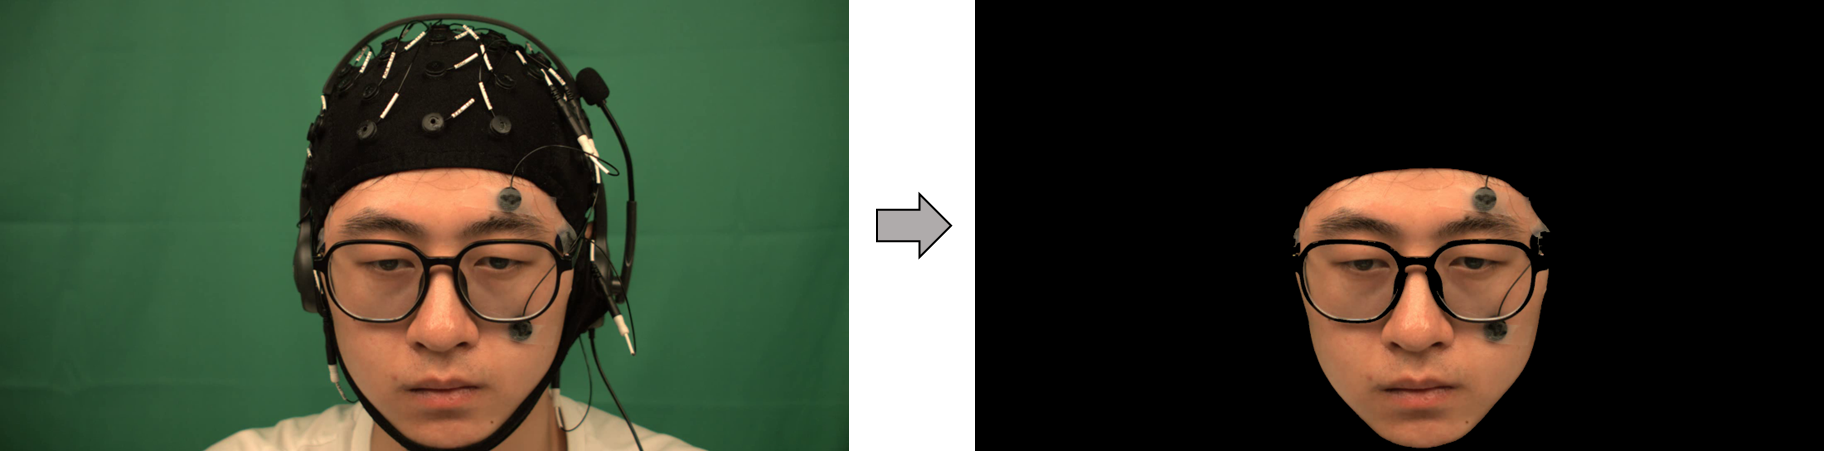

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

exp_type = 'Micro'

In [2]:
def segmented_face(pic_crop_path, pic_segment_path, sample, exp_type):
    # 加载图像
    for filename in os.listdir(os.path.join(pic_crop_path, sample)):
        image_path = os.path.join(pic_crop_path, sample, filename)
        print('image_path:', image_path)
        raw_image = cv2.imread(image_path)

        # 获取图像高度
        image_height = raw_image.shape[0]

        # 转换图像为HSV颜色空间
        hsv_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2HSV)

        # 定义用于分割的颜色范围（例子是皮肤颜色范围）
        lower_color = np.array([0, 48, 80], dtype=np.uint8)
        upper_color = np.array([20, 255, 255], dtype=np.uint8)

        # 基于定义的颜色范围创建掩码
        mask = cv2.inRange(hsv_image, lower_color, upper_color)

        # 使用形态学操作闭操作填补小孔
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        # 找到掩码中的轮廓
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # 打印找到的轮廓数量
        print(f"Number of contours found: {len(contours)}")

        # 创建一个新的掩码用于过滤后的轮廓
        filtered_mask = np.zeros_like(mask)

        # 定义一个面积阈值，用于过滤掉小区域
        area_threshold = 20000  # 根据需要调整这个阈值

        # 质心接近图片高度的阈值
        height_threshold = 0.75 * image_height  # 例如，图片高度的80%

        # 过滤轮廓
        valid_contours = []
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > area_threshold:
                # 计算轮廓的质心
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                else:
                    cx, cy = 0, 0

                # 过滤掉质心y坐标接近图片高度的轮廓
                if cy < height_threshold:
                    # 分割接触较小的轮廓
                    split_contours = split_touching_contours(contour)
                    valid_contours.extend(split_contours)

        # 打印过滤后的轮廓数量
        print(f"Number of filtered contours: {len(valid_contours)}")

        # 在新的掩码上绘制过滤后的轮廓
        for contour in valid_contours:
            cv2.drawContours(filtered_mask, [contour], -1, (255), thickness=cv2.FILLED)

        # 将过滤后的掩码应用到原始图像上
        segmented_image = cv2.bitwise_and(raw_image, raw_image, mask=filtered_mask)

        # 用红线绘制分割和过滤后的轮廓
#         result_image = segmented_image.copy()
#         for contour in valid_contours:
#             cv2.drawContours(result_image, [contour], -1, (0, 0, 255), thickness=2)

        # 保存分割后的图像
        output_path = os.path.join(pic_segment_path, exp_type, sample)
        os.makedirs(output_path, exist_ok=True)
        output_pic_path = os.path.join(output_path, filename)
        cv2.imwrite(output_pic_path, segmented_image)
        print(f"Segmented image saved to {output_pic_path}")

        # 保存绘制轮廓后的图像
#         output_contour_path = os.path.join(output_path, filename)
#         cv2.imwrite(output_contour_path, result_image)
#         print(f"Contour image saved to {output_contour_path}")
        print('-------------------------------------------------------------------------')

In [4]:
pic_select_path = os.path.join('1.pics_selected', exp_type)
os.makedirs(pic_select_path, exist_ok=True)

pic_segment_path = '2.pics_selected_segmented'

for sample in os.listdir(pic_select_path):
    segmented_face(pic_select_path, pic_segment_path, sample, exp_type)

分割单张图片

In [11]:
import cv2
import numpy as np

def split_touching_contours(mask):
    """
    分离相互接触的轮廓
    :param mask: 输入的二值化掩码图像
    :return: 分离后的轮廓列表
    """
    # 确保掩码是二值化的，并且数据类型为 uint8
    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8)

    # 对掩码进行形态学膨胀操作
    kernel = np.ones((5, 5), np.uint8)  # 选择一个合适的内核大小
    dilated_mask = cv2.dilate(mask, kernel, iterations=1)

    # 找到膨胀后的轮廓
    contours, _ = cv2.findContours(dilated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 创建一个新的空白图像以绘制分离的轮廓
    separated_mask = np.zeros_like(mask)

    # 遍历所有轮廓，绘制到空白图像中
    for contour in contours:
        cv2.drawContours(separated_mask, [contour], -1, 255, thickness=cv2.FILLED)

    # 进行腐蚀操作，以增强轮廓之间的分离
    eroded_mask = cv2.erode(separated_mask, kernel, iterations=1)

    # 找到腐蚀后的轮廓
    final_contours, _ = cv2.findContours(eroded_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    return final_contours

# 读取图像
raw_image = cv2.imread(r'E:\10.Doctoral materials\0.Micro-expression\3.papers\ICMR-ME+EEG\pics\p7.png')

# 获取图像高度
image_height = raw_image.shape[0]

# 转换图像为HSV颜色空间
hsv_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2HSV)

# 定义用于分割的颜色范围（例子是皮肤颜色范围）
lower_color = np.array([0, 48, 80], dtype=np.uint8)
upper_color = np.array([20, 255, 255], dtype=np.uint8)

# 基于定义的颜色范围创建掩码
mask = cv2.inRange(hsv_image, lower_color, upper_color)

# 使用形态学操作闭操作填补小孔
kernel = np.ones((5, 5), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# 找到掩码中的轮廓
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 打印找到的轮廓数量
print(f"Number of contours found: {len(contours)}")

# 创建一个新的掩码用于过滤后的轮廓
filtered_mask = np.zeros_like(mask)

# 定义一个面积阈值，用于过滤掉小区域
area_threshold = 20000  # 根据需要调整这个阈值

# 质心接近图片高度的阈值
height_threshold = 0.75 * image_height  # 例如，图片高度的80%

# 过滤轮廓
valid_contours = []
for contour in contours:
    area = cv2.contourArea(contour)
    if area > area_threshold:
        # 计算轮廓的质心
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
        else:
            cx, cy = 0, 0

        # 过滤掉质心 y 坐标接近图片高度的轮廓
        if cy < height_threshold:
            # 创建一个掩码图像，绘制当前轮廓
            contour_mask = np.zeros_like(mask)
            cv2.drawContours(contour_mask, [contour], -1, 255, thickness=cv2.FILLED)

            # 分割接触较小的轮廓
            split_contours = split_touching_contours(contour_mask)
            valid_contours.extend(split_contours)

# 打印过滤后的轮廓数量
print(f"Number of filtered contours: {len(valid_contours)}")

# 在新的掩码上绘制过滤后的轮廓
for contour in valid_contours:
    cv2.drawContours(filtered_mask, [contour], -1, (255), thickness=cv2.FILLED)

# 将过滤后的掩码应用到原始图像上
segmented_image = cv2.bitwise_and(raw_image, raw_image, mask=filtered_mask)

# 保存结果
cv2.imwrite(r'E:\10.Doctoral materials\0.Micro-expression\3.papers\ICMR-ME+EEG\pics\p7-s.png', segmented_image)

Number of contours found: 52
Number of filtered contours: 2


True

## 测试单张图片

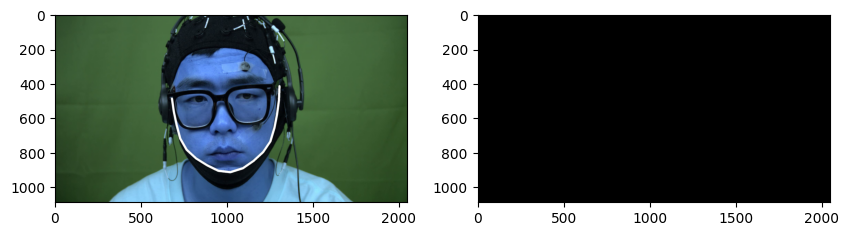

In [112]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

# 读取图像并复制
image_path = r'1.pics_selected\Macro\angry_wangshuai20230802_146_3.14_3.62_3.62\apex.png'
raw_image = cv2.imread(image_path)
result_image = raw_image.copy()

# 获取图像高度
image_height = raw_image.shape[0]

# 转换图像为HSV颜色空间
hsv_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2HSV)

# 定义用于分割皮肤的颜色范围
lower_color = np.array([0, 48, 80], dtype=np.uint8)
upper_color = np.array([20, 255, 255], dtype=np.uint8)

# 基于定义的颜色范围创建掩码
mask = cv2.inRange(hsv_image, lower_color, upper_color)

# 使用形态学操作闭操作填补小孔
kernel = np.ones((3, 3), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# 找到掩码中的轮廓
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 创建一个新的掩码用于过滤后的轮廓
filtered_mask = np.zeros_like(mask)

# 定义一个面积阈值，用于过滤掉小区域
area_threshold = 20000  # 根据需要调整这个阈值

# 质心接近图片高度的阈值
height_threshold = 0.75 * image_height  # 例如，图片高度的80%

# 过滤轮廓
valid_contours = []
for contour in contours:
    area = cv2.contourArea(contour)
    if area > area_threshold:
        # 计算轮廓的质心
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
        else:
            cx, cy = 0, 0

        # 过滤掉质心y坐标接近图片高度的轮廓
        if cy < height_threshold:
            valid_contours.extend([contour])
            
# 检测面部
gray_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2GRAY)
faces = detector(gray_image)
landmarks = predictor(gray_image, faces[0])

# 提取下颌线特征点   
jaw_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(17)]

# 获取下颌线的y坐标值
jaw_x = [point[0] for point in jaw_points]
jaw_y = [point[1] for point in jaw_points]

# 创建插值函数
jaw_line = np.polyfit(jaw_x, jaw_y, 12)
jaw_poly = np.poly1d(jaw_line)

# 绘制下颌线
for i in range(len(jaw_points) - 1):
    cv2.line(result_image, jaw_points[i], jaw_points[i + 1], (255, 255, 255), 12)

# 检查每个轮廓中的点，如果在下颌线下方则删除
for contour in valid_contours:
    to_remove = []
    for point in contour:
        x, y = point[0]
        jaw_y_at_x = jaw_poly(x)
        if y > jaw_y_at_x:  # 点在下颌线下方
            to_remove.append(point)

    # 删除在下颌线下方的点
    for point in to_remove:
        contour = np.delete(contour, np.where((contour == point).all(axis=2))[0], axis=0)

# 绘制过滤后的轮廓
for contour in filtered_contours:
    cv2.drawContours(result_image, [contour], -1, (255), thickness=cv2.FILLED)
    cv2.drawContours(filtered_mask, [contour], -1, (255), thickness=cv2.FILLED)
    
# 将过滤后的掩码应用到原始图像上
segmented_image = cv2.bitwise_and(raw_image, raw_image, mask=filtered_mask)

# 显示结果
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # You can adjust the figsize as needed
axes[0].imshow(result_image)
axes[1].imshow(segmented_image)
plt.show()

## 裁剪面部区域为(256, 256)

- 存入3.pics_selected_segmented_cropped

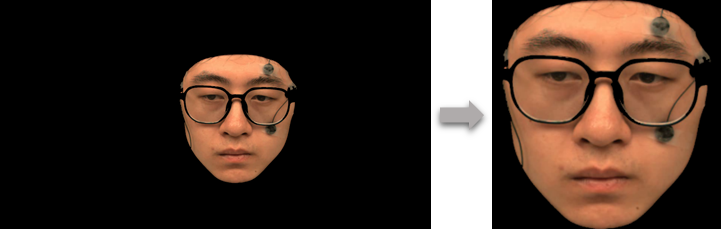

In [5]:
def crop_and_pad_face(segmented_path, crop_path, sample, exp_type, target_size=(256, 256)):
    # Load the image
    for filename in os.listdir(os.path.join(segmented_path, sample)):
        image_path = os.path.join(segmented_path, sample, filename)
        print('image_path:', image_path)
        image = cv2.imread(image_path)

        # Convert image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Threshold the image to create a binary mask
        _, binary_mask = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY)

        # Find contours in the mask
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # If no contours found, return None
        if len(contours) == 0:
            print("No contours found in the image")
            return

        # Merge contours if there are more than one
        if len(contours) > 1:
            contours_combined = np.vstack(contours)
            x, y, w, h = cv2.boundingRect(contours_combined)
        else:
            x, y, w, h = cv2.boundingRect(contours[0])

        # Crop the image using the bounding box coordinates
        cropped_image = image[y:y+h, x:x+w]

        # Calculate padding to maintain aspect ratio
        height, width, _ = cropped_image.shape
        target_width, target_height = target_size
        if width > height:
            pad_top = (width - height) // 2
            pad_bottom = width - height - pad_top
            pad_left = 0
            pad_right = 0
        else:
            pad_left = (height - width) // 2
            pad_right = height - width - pad_left
            pad_top = 0
            pad_bottom = 0

        # Apply padding
        padded_image = cv2.copyMakeBorder(cropped_image, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

        # Resize the padded image to the target size
        resized_image = cv2.resize(padded_image, target_size, interpolation=cv2.INTER_AREA)
        
        # 保存裁剪后的图像
        output_path = os.path.join(crop_path, exp_type, sample)
        os.makedirs(output_path, exist_ok=True)
        output_pic_path = os.path.join(output_path, filename)
        cv2.imwrite(output_pic_path, resized_image)

In [6]:
exp_type = 'Micro'

segment_path = os.path.join('2.pics_selected_segmented', exp_type)

crop_path = '3.pics_selected_segmented_cropped'

for sample in os.listdir(segment_path):
    crop_and_pad_face(segment_path, crop_path, sample, exp_type, target_size=(256, 256))

image_path: 2.pics_selected_segmented\Micro\angry_liyan20230802_116_1.70_1.97_2.20\apex.png
image_path: 2.pics_selected_segmented\Micro\angry_liyan20230802_116_1.70_1.97_2.20\onset.png
image_path: 2.pics_selected_segmented\Micro\angry_liyan20230802_116_10.06_10.25_10.50\apex.png
image_path: 2.pics_selected_segmented\Micro\angry_liyan20230802_116_10.06_10.25_10.50\onset.png
image_path: 2.pics_selected_segmented\Micro\angry_liyan20230802_116_41.29_41.57_41.76\apex.png
image_path: 2.pics_selected_segmented\Micro\angry_liyan20230802_116_41.29_41.57_41.76\onset.png
image_path: 2.pics_selected_segmented\Micro\angry_wangshuai20230802_107_28.25_28.50_28.70\apex.png
image_path: 2.pics_selected_segmented\Micro\angry_wangshuai20230802_107_28.25_28.50_28.70\onset.png
image_path: 2.pics_selected_segmented\Micro\angry_wangshuai20230802_107_29.44_29.84_29.84\apex.png
image_path: 2.pics_selected_segmented\Micro\angry_wangshuai20230802_107_29.44_29.84_29.84\onset.png
image_path: 2.pics_selected_segment

image_path: 2.pics_selected_segmented\Micro\disgust_fengdengfang20230802_110_36.50_36.63_36.77\onset.png
image_path: 2.pics_selected_segmented\Micro\disgust_fengdengfang20230802_112_41.42_41.81_41.99\apex.png
image_path: 2.pics_selected_segmented\Micro\disgust_fengdengfang20230802_112_41.42_41.81_41.99\onset.png
image_path: 2.pics_selected_segmented\Micro\disgust_liyan20230802_112_46.24_46.60_46.60\apex.png
image_path: 2.pics_selected_segmented\Micro\disgust_liyan20230802_112_46.24_46.60_46.60\onset.png
image_path: 2.pics_selected_segmented\Micro\disgust_wangshuai20230802_119_7.45_7.80_7.89\apex.png
image_path: 2.pics_selected_segmented\Micro\disgust_wangshuai20230802_119_7.45_7.80_7.89\onset.png
image_path: 2.pics_selected_segmented\Micro\disgust_wangxiaomin20230718_102_52.90_53.15_53.15\apex.png
image_path: 2.pics_selected_segmented\Micro\disgust_wangxiaomin20230718_102_52.90_53.15_53.15\onset.png
image_path: 2.pics_selected_segmented\Micro\disgust_wangxiaomin20230718_110_15.32_15.57

image_path: 2.pics_selected_segmented\Micro\disgust_zhaoshaohua20230801_110_21.01_21.34_21.51\apex.png
image_path: 2.pics_selected_segmented\Micro\disgust_zhaoshaohua20230801_110_21.01_21.34_21.51\onset.png
image_path: 2.pics_selected_segmented\Micro\disgust_zhaoshaohua20230801_110_21.21_21.33_21.46\apex.png
image_path: 2.pics_selected_segmented\Micro\disgust_zhaoshaohua20230801_110_21.21_21.33_21.46\onset.png
image_path: 2.pics_selected_segmented\Micro\disgust_zhaoshaohua20230801_110_24.18_24.44_24.61\apex.png
image_path: 2.pics_selected_segmented\Micro\disgust_zhaoshaohua20230801_110_24.18_24.44_24.61\onset.png
image_path: 2.pics_selected_segmented\Micro\disgust_zhaoshaohua20230801_110_3.75_3.96_4.22\apex.png
image_path: 2.pics_selected_segmented\Micro\disgust_zhaoshaohua20230801_110_3.75_3.96_4.22\onset.png
image_path: 2.pics_selected_segmented\Micro\disgust_zhaoshaohua20230801_110_3.85_4.02_4.20\apex.png
image_path: 2.pics_selected_segmented\Micro\disgust_zhaoshaohua20230801_110_3.

image_path: 2.pics_selected_segmented\Micro\fear_yangmi20230728_121_1.89_2.06_2.23\apex.png
image_path: 2.pics_selected_segmented\Micro\fear_yangmi20230728_121_1.89_2.06_2.23\onset.png
image_path: 2.pics_selected_segmented\Micro\fear_yangmi20230728_121_1.95_2.10_2.34\apex.png
image_path: 2.pics_selected_segmented\Micro\fear_yangmi20230728_121_1.95_2.10_2.34\onset.png
image_path: 2.pics_selected_segmented\Micro\fear_yangmi20230728_121_14.22_14.47_14.55\apex.png
image_path: 2.pics_selected_segmented\Micro\fear_yangmi20230728_121_14.22_14.47_14.55\onset.png
image_path: 2.pics_selected_segmented\Micro\fear_yangmi20230728_121_14.24_14.41_14.74\apex.png
image_path: 2.pics_selected_segmented\Micro\fear_yangmi20230728_121_14.24_14.41_14.74\onset.png
image_path: 2.pics_selected_segmented\Micro\fear_yangmi20230728_121_17.54_17.71_17.88\apex.png
image_path: 2.pics_selected_segmented\Micro\fear_yangmi20230728_121_17.54_17.71_17.88\onset.png
image_path: 2.pics_selected_segmented\Micro\fear_yangmi20

image_path: 2.pics_selected_segmented\Micro\happy_yangmi20230728_120_35.28_35.53_35.75\apex.png
image_path: 2.pics_selected_segmented\Micro\happy_yangmi20230728_120_35.28_35.53_35.75\onset.png
image_path: 2.pics_selected_segmented\Micro\happy_yangmi20230728_129_40.05_40.30_40.30\apex.png
image_path: 2.pics_selected_segmented\Micro\happy_yangmi20230728_129_40.05_40.30_40.30\onset.png
image_path: 2.pics_selected_segmented\Micro\happy_yangmi20230728_129_53.51_53.76_53.76\apex.png
image_path: 2.pics_selected_segmented\Micro\happy_yangmi20230728_129_53.51_53.76_53.76\onset.png
image_path: 2.pics_selected_segmented\Micro\happy_yansen20230731_120_6.60_7.33_7.33\apex.png
image_path: 2.pics_selected_segmented\Micro\happy_yansen20230731_120_6.60_7.33_7.33\onset.png
image_path: 2.pics_selected_segmented\Micro\happy_yansen20230731_123_4.90_5.20_5.20\apex.png
image_path: 2.pics_selected_segmented\Micro\happy_yansen20230731_123_4.90_5.20_5.20\onset.png
image_path: 2.pics_selected_segmented\Micro\hap

image_path: 2.pics_selected_segmented\Micro\sad_wangxiaomin20230718_127_44.34_44.53_44.53\apex.png
image_path: 2.pics_selected_segmented\Micro\sad_wangxiaomin20230718_127_44.34_44.53_44.53\onset.png
image_path: 2.pics_selected_segmented\Micro\sad_wangxiaomin20230718_127_7.70_7.90_7.90\apex.png
image_path: 2.pics_selected_segmented\Micro\sad_wangxiaomin20230718_127_7.70_7.90_7.90\onset.png
image_path: 2.pics_selected_segmented\Micro\sad_wangxiaomin20230718_136_17.81_18.01_18.30\apex.png
image_path: 2.pics_selected_segmented\Micro\sad_wangxiaomin20230718_136_17.81_18.01_18.30\onset.png
image_path: 2.pics_selected_segmented\Micro\sad_wangxiaomin20230718_136_19.44_19.76_20.00\apex.png
image_path: 2.pics_selected_segmented\Micro\sad_wangxiaomin20230718_136_19.44_19.76_20.00\onset.png
image_path: 2.pics_selected_segmented\Micro\sad_wangxiaomin20230718_136_19.54_19.77_19.98\apex.png
image_path: 2.pics_selected_segmented\Micro\sad_wangxiaomin20230718_136_19.54_19.77_19.98\onset.png
image_path:

image_path: 2.pics_selected_segmented\Micro\surprise_wangshuai20230802_126_11.32_11.46_11.75\onset.png
image_path: 2.pics_selected_segmented\Micro\surprise_wangshuai20230802_126_25.05_25.20_25.20\apex.png
image_path: 2.pics_selected_segmented\Micro\surprise_wangshuai20230802_126_25.05_25.20_25.20\onset.png
image_path: 2.pics_selected_segmented\Micro\surprise_wangziheng20230727_147_50.82_50.90_51.03\apex.png
image_path: 2.pics_selected_segmented\Micro\surprise_wangziheng20230727_147_50.82_50.90_51.03\onset.png
image_path: 2.pics_selected_segmented\Micro\surprise_wangzishan20230717_108_12.28_12.48_12.79\apex.png
image_path: 2.pics_selected_segmented\Micro\surprise_wangzishan20230717_108_12.28_12.48_12.79\onset.png
image_path: 2.pics_selected_segmented\Micro\surprise_wangzishan20230717_126_18.68_18.90_18.90\apex.png
image_path: 2.pics_selected_segmented\Micro\surprise_wangzishan20230717_126_18.68_18.90_18.90\onset.png
image_path: 2.pics_selected_segmented\Micro\surprise_wangzishan20230717

## 复制产生的图片，集中查看

In [8]:
import os
import shutil

def copy_and_rename_images(src_path, dest_path):
    # 创建目标路径（如果不存在）
    os.makedirs(dest_path, exist_ok=True)
    
    # 获取所有子文件夹
    subfolders = [f.path for f in os.scandir(src_path) if f.is_dir()]
    
    # 遍历每个子文件夹
    for idx, subfolder in enumerate(subfolders, start=1):
        apex_image = os.path.join(subfolder, 'apex.png')
        onset_image = os.path.join(subfolder, 'onset.png')
        
        file_name = os.path.basename(subfolder)
        
        if os.path.exists(apex_image) and os.path.exists(onset_image):
            # 构建新的文件名
            new_apex_name = f"{idx}-2-apex-{file_name}.png"
            new_onset_name = f"{idx}-1-onset-{file_name}.png"
            
            # 构建目标文件路径
            dest_apex_image = os.path.join(dest_path, new_apex_name)
            dest_onset_image = os.path.join(dest_path, new_onset_name)
            
            # 复制并重命名文件
            shutil.copy2(apex_image, dest_apex_image)
            shutil.copy2(onset_image, dest_onset_image)
            
            print(f"Copied and renamed {apex_image} to {dest_apex_image}")
            print(f"Copied and renamed {onset_image} to {dest_onset_image}")
        else:
            print(f"Skipped {subfolder} as it does not contain both apex.png and onset.png")

            
exp_type = 'Macro'
src_path = os.path.join('3.pics_selected_segmented_cropped', exp_type)
dest_path = os.path.join('result', exp_type)
print('dest_path:', dest_path)
copy_and_rename_images(src_path, dest_path)

dest_path: result\Macro
Copied and renamed 3.pics_selected_segmented_cropped\Macro\angry_fengdengfang20230802_107_19.06_19.44_19.70\apex.png to result\Macro\1-2-apex-angry_fengdengfang20230802_107_19.06_19.44_19.70.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\angry_fengdengfang20230802_107_19.06_19.44_19.70\onset.png to result\Macro\1-1-onset-angry_fengdengfang20230802_107_19.06_19.44_19.70.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\angry_fengdengfang20230802_142_16.80_17.17_17.44\apex.png to result\Macro\2-2-apex-angry_fengdengfang20230802_142_16.80_17.17_17.44.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\angry_fengdengfang20230802_142_16.80_17.17_17.44\onset.png to result\Macro\2-1-onset-angry_fengdengfang20230802_142_16.80_17.17_17.44.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\angry_fengdengfang20230802_142_3.00_3.19_3.63\apex.png to result\Macro\3-2-apex-angry_fengdengfang20230802_142_3.00_3.19_3.63.png
Cop

Copied and renamed 3.pics_selected_segmented_cropped\Macro\angry_wangziheng20230727_125_15.50_15.77_16.04\apex.png to result\Macro\54-2-apex-angry_wangziheng20230727_125_15.50_15.77_16.04.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\angry_wangziheng20230727_125_15.50_15.77_16.04\onset.png to result\Macro\54-1-onset-angry_wangziheng20230727_125_15.50_15.77_16.04.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\angry_wangziheng20230727_142_36.74_37.46_38.28\apex.png to result\Macro\55-2-apex-angry_wangziheng20230727_142_36.74_37.46_38.28.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\angry_wangziheng20230727_142_36.74_37.46_38.28\onset.png to result\Macro\55-1-onset-angry_wangziheng20230727_142_36.74_37.46_38.28.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\angry_wangzishan20230717_107_17.55_18.28_18.70\apex.png to result\Macro\56-2-apex-angry_wangzishan20230717_107_17.55_18.28_18.70.png
Copied and renamed 3.pics_selected_s

Copied and renamed 3.pics_selected_segmented_cropped\Macro\angry_zhengwansheng20230718_142_31.92_32.28_32.28\apex.png to result\Macro\109-2-apex-angry_zhengwansheng20230718_142_31.92_32.28_32.28.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\angry_zhengwansheng20230718_142_31.92_32.28_32.28\onset.png to result\Macro\109-1-onset-angry_zhengwansheng20230718_142_31.92_32.28_32.28.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\angry_zhengwansheng20230718_142_32.54_33.08_33.44\apex.png to result\Macro\110-2-apex-angry_zhengwansheng20230718_142_32.54_33.08_33.44.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\angry_zhengwansheng20230718_142_32.54_33.08_33.44\onset.png to result\Macro\110-1-onset-angry_zhengwansheng20230718_142_32.54_33.08_33.44.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\angry_zhengwansheng20230718_142_42.45_43.35_44.25\apex.png to result\Macro\111-2-apex-angry_zhengwansheng20230718_142_42.45_43.35_44.25.png
C

Copied and renamed 3.pics_selected_segmented_cropped\Macro\disgust_yangmi20230728_102_12.99_13.54_13.54\apex.png to result\Macro\163-2-apex-disgust_yangmi20230728_102_12.99_13.54_13.54.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\disgust_yangmi20230728_102_12.99_13.54_13.54\onset.png to result\Macro\163-1-onset-disgust_yangmi20230728_102_12.99_13.54_13.54.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\disgust_yangmi20230728_102_17.59_18.14_18.14\apex.png to result\Macro\164-2-apex-disgust_yangmi20230728_102_17.59_18.14_18.14.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\disgust_yangmi20230728_102_17.59_18.14_18.14\onset.png to result\Macro\164-1-onset-disgust_yangmi20230728_102_17.59_18.14_18.14.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\disgust_yangmi20230728_102_18.94_19.31_19.31\apex.png to result\Macro\165-2-apex-disgust_yangmi20230728_102_18.94_19.31_19.31.png
Copied and renamed 3.pics_selected_segmented_croppe

Copied and renamed 3.pics_selected_segmented_cropped\Macro\disgust_zhaoshaohua20230801_110_20.91_22.10_22.10\apex.png to result\Macro\197-2-apex-disgust_zhaoshaohua20230801_110_20.91_22.10_22.10.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\disgust_zhaoshaohua20230801_110_20.91_22.10_22.10\onset.png to result\Macro\197-1-onset-disgust_zhaoshaohua20230801_110_20.91_22.10_22.10.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\disgust_zhaoshaohua20230801_110_28.90_29.30_29.30\apex.png to result\Macro\198-2-apex-disgust_zhaoshaohua20230801_110_28.90_29.30_29.30.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\disgust_zhaoshaohua20230801_110_28.90_29.30_29.30\onset.png to result\Macro\198-1-onset-disgust_zhaoshaohua20230801_110_28.90_29.30_29.30.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\disgust_zhaoshaohua20230801_110_4.40_4.91_5.63\apex.png to result\Macro\199-2-apex-disgust_zhaoshaohua20230801_110_4.40_4.91_5.63.png
Copied 

Copied and renamed 3.pics_selected_segmented_cropped\Macro\disgust_zhengwansheng20230718_128_12.02_13.25_13.25\apex.png to result\Macro\253-2-apex-disgust_zhengwansheng20230718_128_12.02_13.25_13.25.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\disgust_zhengwansheng20230718_128_12.02_13.25_13.25\onset.png to result\Macro\253-1-onset-disgust_zhengwansheng20230718_128_12.02_13.25_13.25.png
Skipped 3.pics_selected_segmented_cropped\Macro\disgust_zhengwansheng20230718_128_15.45_15.90_15.90 as it does not contain both apex.png and onset.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\disgust_zhengwansheng20230718_128_15.66_16.02_16.56\apex.png to result\Macro\255-2-apex-disgust_zhengwansheng20230718_128_15.66_16.02_16.56.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\disgust_zhengwansheng20230718_128_15.66_16.02_16.56\onset.png to result\Macro\255-1-onset-disgust_zhengwansheng20230718_128_15.66_16.02_16.56.png
Copied and renamed 3.pics_selecte

Copied and renamed 3.pics_selected_segmented_cropped\Macro\fear_zhengwansheng20230718_113_35.82_36.17_36.42\apex.png to result\Macro\307-2-apex-fear_zhengwansheng20230718_113_35.82_36.17_36.42.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\fear_zhengwansheng20230718_113_35.82_36.17_36.42\onset.png to result\Macro\307-1-onset-fear_zhengwansheng20230718_113_35.82_36.17_36.42.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\fear_zhengwansheng20230718_113_36.84_37.44_38.13\apex.png to result\Macro\308-2-apex-fear_zhengwansheng20230718_113_36.84_37.44_38.13.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\fear_zhengwansheng20230718_113_36.84_37.44_38.13\onset.png to result\Macro\308-1-onset-fear_zhengwansheng20230718_113_36.84_37.44_38.13.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\fear_zhengwansheng20230718_121_1.68_1.93_1.93\apex.png to result\Macro\309-2-apex-fear_zhengwansheng20230718_121_1.68_1.93_1.93.png
Copied and rename

Copied and renamed 3.pics_selected_segmented_cropped\Macro\happy_wangxiaomin20230718_111_15.21_15.63_15.63\apex.png to result\Macro\361-2-apex-happy_wangxiaomin20230718_111_15.21_15.63_15.63.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\happy_wangxiaomin20230718_111_15.21_15.63_15.63\onset.png to result\Macro\361-1-onset-happy_wangxiaomin20230718_111_15.21_15.63_15.63.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\happy_wangxiaomin20230718_111_15.29_15.71_15.71\apex.png to result\Macro\362-2-apex-happy_wangxiaomin20230718_111_15.29_15.71_15.71.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\happy_wangxiaomin20230718_111_15.29_15.71_15.71\onset.png to result\Macro\362-1-onset-happy_wangxiaomin20230718_111_15.29_15.71_15.71.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\happy_wangxiaomin20230718_111_25.37_26.47_26.47\apex.png to result\Macro\363-2-apex-happy_wangxiaomin20230718_111_25.37_26.47_26.47.png
Copied and renamed 3.

Copied and renamed 3.pics_selected_segmented_cropped\Macro\happy_wangzishan20230717_120_29.50_30.25_30.25\apex.png to result\Macro\419-2-apex-happy_wangzishan20230717_120_29.50_30.25_30.25.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\happy_wangzishan20230717_120_29.50_30.25_30.25\onset.png to result\Macro\419-1-onset-happy_wangzishan20230717_120_29.50_30.25_30.25.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\happy_wangzishan20230717_120_29.87_30.33_30.99\apex.png to result\Macro\420-2-apex-happy_wangzishan20230717_120_29.87_30.33_30.99.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\happy_wangzishan20230717_120_29.87_30.33_30.99\onset.png to result\Macro\420-1-onset-happy_wangzishan20230717_120_29.87_30.33_30.99.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\happy_wangzishan20230717_120_37.89_38.64_38.64\apex.png to result\Macro\421-2-apex-happy_wangzishan20230717_120_37.89_38.64_38.64.png
Copied and renamed 3.pics_selec

Copied and renamed 3.pics_selected_segmented_cropped\Macro\happy_zhangbuyuan20230801_123_6.56_7.28_7.28\apex.png to result\Macro\476-2-apex-happy_zhangbuyuan20230801_123_6.56_7.28_7.28.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\happy_zhangbuyuan20230801_123_6.56_7.28_7.28\onset.png to result\Macro\476-1-onset-happy_zhangbuyuan20230801_123_6.56_7.28_7.28.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\happy_zhangbuyuan20230801_129_46.11_46.64_47.06\apex.png to result\Macro\477-2-apex-happy_zhangbuyuan20230801_129_46.11_46.64_47.06.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\happy_zhangbuyuan20230801_129_46.11_46.64_47.06\onset.png to result\Macro\477-1-onset-happy_zhangbuyuan20230801_129_46.11_46.64_47.06.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\happy_zhangdi20230721_103_30.06_31.14_31.14\apex.png to result\Macro\478-2-apex-happy_zhangdi20230721_103_30.06_31.14_31.14.png
Copied and renamed 3.pics_selected_segmen

Copied and renamed 3.pics_selected_segmented_cropped\Macro\happy_zhengwansheng20230718_138_57.53_58.94_58.94\apex.png to result\Macro\518-2-apex-happy_zhengwansheng20230718_138_57.53_58.94_58.94.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\happy_zhengwansheng20230718_138_57.53_58.94_58.94\onset.png to result\Macro\518-1-onset-happy_zhengwansheng20230718_138_57.53_58.94_58.94.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\sad_fengdengfang20230802_136_46.06_46.72_47.00\apex.png to result\Macro\519-2-apex-sad_fengdengfang20230802_136_46.06_46.72_47.00.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\sad_fengdengfang20230802_136_46.06_46.72_47.00\onset.png to result\Macro\519-1-onset-sad_fengdengfang20230802_136_46.06_46.72_47.00.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\sad_linjiaying20230719_101_46.04_47.17_48.68\apex.png to result\Macro\520-2-apex-sad_linjiaying20230719_101_46.04_47.17_48.68.png
Copied and renamed 3.pi

Copied and renamed 3.pics_selected_segmented_cropped\Macro\sad_wangxiaomin20230718_127_39.90_40.47_42.67\apex.png to result\Macro\541-2-apex-sad_wangxiaomin20230718_127_39.90_40.47_42.67.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\sad_wangxiaomin20230718_127_39.90_40.47_42.67\onset.png to result\Macro\541-1-onset-sad_wangxiaomin20230718_127_39.90_40.47_42.67.png
Skipped 3.pics_selected_segmented_cropped\Macro\sad_wangxiaomin20230718_127_4.00_4.37_4.37 as it does not contain both apex.png and onset.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\sad_wangxiaomin20230718_127_4.06_4.33_4.33\apex.png to result\Macro\543-2-apex-sad_wangxiaomin20230718_127_4.06_4.33_4.33.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\sad_wangxiaomin20230718_127_4.06_4.33_4.33\onset.png to result\Macro\543-1-onset-sad_wangxiaomin20230718_127_4.06_4.33_4.33.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\sad_wangxiaomin20230718_127_40.34_40.62_40.

Copied and renamed 3.pics_selected_segmented_cropped\Macro\sad_zhangbuyuan20230801_148_22.29_22.60_22.80\apex.png to result\Macro\573-2-apex-sad_zhangbuyuan20230801_148_22.29_22.60_22.80.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\sad_zhangbuyuan20230801_148_22.29_22.60_22.80\onset.png to result\Macro\573-1-onset-sad_zhangbuyuan20230801_148_22.29_22.60_22.80.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\sad_zhaoshaohua20230801_109_22.05_22.98_22.98\apex.png to result\Macro\574-2-apex-sad_zhaoshaohua20230801_109_22.05_22.98_22.98.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\sad_zhaoshaohua20230801_109_22.05_22.98_22.98\onset.png to result\Macro\574-1-onset-sad_zhaoshaohua20230801_109_22.05_22.98_22.98.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\sad_zhaoshaohua20230801_118_40.16_40.77_41.04\apex.png to result\Macro\575-2-apex-sad_zhaoshaohua20230801_118_40.16_40.77_41.04.png
Copied and renamed 3.pics_selected_segmen

Copied and renamed 3.pics_selected_segmented_cropped\Macro\tense_wangxiaomin20230718_144_22.30_22.85_22.85\apex.png to result\Macro\627-2-apex-tense_wangxiaomin20230718_144_22.30_22.85_22.85.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\tense_wangxiaomin20230718_144_22.30_22.85_22.85\onset.png to result\Macro\627-1-onset-tense_wangxiaomin20230718_144_22.30_22.85_22.85.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\tense_wangxiaomin20230718_144_52.90_53.27_53.27\apex.png to result\Macro\628-2-apex-tense_wangxiaomin20230718_144_52.90_53.27_53.27.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\tense_wangxiaomin20230718_144_52.90_53.27_53.27\onset.png to result\Macro\628-1-onset-tense_wangxiaomin20230718_144_52.90_53.27_53.27.png
Copied and renamed 3.pics_selected_segmented_cropped\Macro\tense_wangxiaomin20230718_144_7.00_7.46_7.46\apex.png to result\Macro\629-2-apex-tense_wangxiaomin20230718_144_7.00_7.46_7.46.png
Copied and renamed 3.pics_s

- Micro: 18（严重不对齐）、25(过于微弱)、36（严重不对齐）、55（严重不对齐）、66（严重不对齐）、69（严重不对齐）、78（严重不对齐）、90（严重不对齐）、119（不对齐）、124（不对齐）、138（严重不对齐）、120（动作微弱）

## 面部对齐

### 鼻尖对齐

In [32]:
# 计算鼻子质心
def calculate_nose_centroid(landmarks):
    points_nose = np.array([[landmarks[i][0], landmarks[i][1]] for i in range(58, 63)])
    return points_nose.mean(axis=0)

# 应用仿射变换对图像进行质心对齐
def align_images_by_nose_centroid(src_image, src_landmarks, dst_image, dst_landmarks):
    src_nose_centroid = calculate_nose_centroid(src_landmarks)
    dst_nose_centroid = calculate_nose_centroid(dst_landmarks)

    # 计算平移向量
    tx = dst_nose_centroid[0] - src_nose_centroid[0]
    ty = dst_nose_centroid[1] - src_nose_centroid[1]

    # 创建平移矩阵
    M_translation = np.float32([[1, 0, tx], [0, 1, ty]])

    # 获取目标图像的尺寸
    h, w = dst_image.shape[:2]

    # 应用平移变换
    aligned_image = cv2.warpAffine(src_image, M_translation, (w, h))

    return aligned_image

def get_align_image(onset_path, apex_path, aligned_onset_path):
    onset = cv2.imread(onset_path)
    apex = cv2.imread(apex_path)
    
    F_onset, L_onset = face_reg_alibabacloud(onset_path)
    # 将表示方式转换为坐标对列表
    landmarks_onset = [(int(L_onset[i]), int(L_onset[i + 1])) for i in range(0, len(L_onset), 2)]
    
    F_apex, L_apex = face_reg_alibabacloud(apex_path)
    # 将表示方式转换为坐标对列表
    landmarks_apex = [(int(L_apex[i]), int(L_apex[i + 1])) for i in range(0, len(L_apex), 2)]

    # 质心对齐
    onset_aligned = align_images_by_nose_centroid(onset, landmarks_onset, apex, landmarks_apex)

    # 保存质心对齐后的图像到文件
    cv2.imwrite(aligned_onset_path, onset_aligned)

    print(f'{aligned_onset_path}')
    print('align_image success！')

- 首先将'3.pics_selected_segmented_cropped'中的onset.png和apex.png复制到'4.pics_selected_segmented_cropped_align'，然后在'4.pics_selected_segmented_cropped_align'中产生对齐的align_onset_by_nose.png

In [33]:
exp_type = 'Micro'
# exp_type = 'Macro'

source_path = os.path.join('3.pics_selected_segmented_cropped', exp_type)
aligned_path = os.path.join('4.pics_selected_segmented_cropped_align', exp_type)

for sample in os.listdir(source_path):
    onset_path = os.path.join(source_path, sample, 'onset.png')
    apex_path = os.path.join(source_path, sample, 'apex.png')
    
    # 如果两个图片均存在
    if os.path.exists(onset_path) and os.path.exists(apex_path): 
        os.makedirs(os.path.join(aligned_path, sample), exist_ok=True)
        # 复制并重命名文件
        shutil.copy2(onset_path, os.path.join(aligned_path, sample, 'onset.png'))
        shutil.copy2(apex_path, os.path.join(aligned_path, sample, 'apex.png'))

        # 获取对齐后的align_onset_by_nose.png，并存入aligned_onset_path
        aligned_onset_path = os.path.join(aligned_path, sample, 'align_onset_by_nose.png')
        get_align_image(onset_path, apex_path, aligned_onset_path)
    else:
        print('onset.png或apex.png不存在！')
    
#     try:
#         os.remove(os.path.join(aligned_path, sample, 'aligned_onset.png'))
#     except:
#         pass

4.pics_selected_segmented_cropped_align\Micro\angry_liyan20230802_116_1.70_1.97_2.20\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\angry_liyan20230802_116_10.06_10.25_10.50\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\angry_liyan20230802_116_41.29_41.57_41.76\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\angry_wangshuai20230802_107_28.25_28.50_28.70\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\angry_wangshuai20230802_107_29.44_29.84_29.84\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\angry_wangshuai20230802_142_17.51_17.67_17.97\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\angry_wangxiaomin20230718_116_39.78_40.00_40.00\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\angry_wa

4.pics_selected_segmented_cropped_align\Micro\disgust_yangmi20230728_110_20.00_20.17_20.30\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\disgust_yangmi20230728_110_27.71_27.90_28.13\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\disgust_yangmi20230728_110_27.81_27.91_28.04\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\disgust_yangmi20230728_110_41.25_41.50_41.67\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\disgust_yangmi20230728_110_41.33_41.52_41.74\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\disgust_yangmi20230728_110_42.45_42.70_42.70\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\disgust_yangmi20230728_110_46.45_46.65_46.85\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\di

4.pics_selected_segmented_cropped_align\Micro\fear_wangxiaomin20230718_134_18.63_18.79_18.96\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\fear_wangziheng20230727_104_15.34_15.51_15.69\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\fear_wangziheng20230727_104_29.97_30.23_30.45\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\fear_wangziheng20230727_104_42.38_42.55_42.73\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\fear_wangziheng20230727_104_42.42_42.60_42.77\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\fear_wangziheng20230727_113_39.55_39.73_39.98\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\fear_wangziheng20230727_121_31.19_31.27_31.53\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\

4.pics_selected_segmented_cropped_align\Micro\happy_zhaolei20230803_123_23.80_24.05_24.05\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\happy_zhaolei20230803_123_38.52_38.72_38.90\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\happy_zhaolei20230803_123_41.04_41.20_41.44\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\happy_zhaolei20230803_123_41.11_41.27_41.42\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\happy_zhaolei20230803_123_9.48_9.72_9.72\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\happy_zhaoshaohua20230801_103_11.56_11.81_11.81\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\happy_zhaoshaohua20230801_103_11.85_12.18_12.35\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\happ

4.pics_selected_segmented_cropped_align\Micro\sad_zhaoshaohua20230801_118_40.25_40.45_40.45\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\sad_zhaoshaohua20230801_118_5.12_5.25_5.46\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\sad_zhaoshaohua20230801_118_5.13_5.23_5.38\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\sad_zhaoshaohua20230801_127_17.96_18.05_18.23\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\sad_zhaoshaohua20230801_136_11.79_11.98_12.07\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\sad_zhaoshaohua20230801_136_30.85_31.13_31.32\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\sad_zhaoshaohua20230801_148_23.26_23.50_23.50\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\s

- sad_zhengwansheng20230718_118_20.24_20.44_20.74 对齐后效果不好

### 质心对齐（非必须）

In [511]:
# 计算质心
def calculate_centroid(landmarks):
    points = np.array([[landmark[0], landmark[1]] for landmark in landmarks])
    return points.mean(axis=0)

# 应用仿射变换对图像进行质心对齐
def align_images_by_centroid(src_image, src_landmarks, dst_image, dst_landmarks):
    src_centroid = calculate_centroid(src_landmarks)
    dst_centroid = calculate_centroid(dst_landmarks)

    # 计算平移向量
    tx = dst_centroid[0] - src_centroid[0]
    ty = dst_centroid[1] - src_centroid[1]

    # 创建平移矩阵
    M_translation = np.float64([[1, 0, tx], [0, 1, ty]])

    # 获取目标图像的尺寸
    h, w = dst_image.shape[:2]

    # 应用平移变换
    aligned_image = cv2.warpAffine(src_image, M_translation, (w, h))

    return aligned_image

def get_align_image(onset_path, apex_path, aligned_onset_path):
    onset = cv2.imread(onset_path)
    apex = cv2.imread(apex_path)
    
    F_onset, L_onset = face_reg_alibabacloud(onset_path)
    # 将表示方式转换为坐标对列表
    landmarks_onset = [(int(L_onset[i]), int(L_onset[i + 1])) for i in range(0, len(L_onset), 2)]
    
    F_apex, L_apex = face_reg_alibabacloud(apex_path)
    # 将表示方式转换为坐标对列表
    landmarks_apex = [(int(L_apex[i]), int(L_apex[i + 1])) for i in range(0, len(L_apex), 2)]

    # 质心对齐
    onset_aligned = align_images_by_centroid(onset, landmarks_onset, apex, landmarks_apex)

    # 保存质心对齐后的图像到文件
    cv2.imwrite(aligned_onset_path, onset_aligned)
    
    print(f'{aligned_onset_path}')
    print('align_image success！')

In [512]:
exp_type = 'Micro'
# exp_type = 'Macro'

aligned_path = os.path.join(r'E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\pics_selected_cropped_and_aligned', 
                              exp_type)

for sample in os.listdir(aligned_path):
    onset_path = os.path.join(aligned_path, sample, 'align_onset_by_nose.png')
    apex_path = os.path.join(aligned_path, sample, 'apex.png')
    aligned_onset_path = os.path.join(aligned_path, sample, 'align_onset_by_face.png')
    
    get_align_image(onset_path, apex_path, aligned_onset_path)

E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\pics_selected_cropped_and_aligned\Micro\angry_liyan20230802_116_1.70_1.97_2.20\align_onset_by_face.png
align_image success！
E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\pics_selected_cropped_and_aligned\Micro\angry_liyan20230802_116_10.06_10.25_10.50\align_onset_by_face.png
align_image success！
E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\pics_selected_cropped_and_aligned\Micro\angry_liyan20230802_116_41.29_41.57_41.76\align_onset_by_face.png
align_image success！
E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\pics_selected_cropped_and_aligned\Micro\angry_wangshuai20230802_107_28.25_28.50_28.70\align_onset_by_face.png
align_image success！
E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\pics_selected_cropped_and_aligned\Micro\angry_wangshuai20230802_107_29.44_29.84_29.84\align_onset_by_face.png
align_image success！


E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\pics_selected_cropped_and_aligned\Micro\disgust_zhaoshaohua20230801_110_45.35_45.60_45.60\align_onset_by_face.png
align_image success！
E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\pics_selected_cropped_and_aligned\Micro\disgust_zhaoshaohua20230801_112_13.16_13.34_13.61\align_onset_by_face.png
align_image success！
E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\pics_selected_cropped_and_aligned\Micro\disgust_zhaoshaohua20230801_112_18.06_18.33_18.56\align_onset_by_face.png
align_image success！
E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\pics_selected_cropped_and_aligned\Micro\disgust_zhaoshaohua20230801_112_20.92_21.10_21.27\align_onset_by_face.png
align_image success！
E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\pics_selected_cropped_and_aligned\Micro\disgust_zhaoshaohua20230801_112_21.50_22.00_22.00\align_onse

E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\pics_selected_cropped_and_aligned\Micro\happy_wangshuai20230802_111_5.63_5.88_5.88\align_onset_by_face.png
align_image success！
E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\pics_selected_cropped_and_aligned\Micro\happy_wangxiaomin20230718_138_2.70_3.00_3.20\align_onset_by_face.png
align_image success！
E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\pics_selected_cropped_and_aligned\Micro\happy_wangziheng20230727_111_41.54_41.78_41.99\align_onset_by_face.png
align_image success！
E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\pics_selected_cropped_and_aligned\Micro\happy_wangziheng20230727_123_29.25_29.65_29.75\align_onset_by_face.png
align_image success！
E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\pics_selected_cropped_and_aligned\Micro\happy_wangziheng20230727_138_25.99_26.29_26.48\align_onset_by_face.png
align_i

E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\pics_selected_cropped_and_aligned\Micro\sad_zhaoshaohua20230801_101_14.77_15.06_15.06\align_onset_by_face.png
align_image success！
E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\pics_selected_cropped_and_aligned\Micro\sad_zhaoshaohua20230801_101_19.41_19.69_19.90\align_onset_by_face.png
align_image success！
E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\pics_selected_cropped_and_aligned\Micro\sad_zhaoshaohua20230801_101_22.03_22.32_22.50\align_onset_by_face.png
align_image success！
E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\pics_selected_cropped_and_aligned\Micro\sad_zhaoshaohua20230801_101_22.96_23.24_23.42\align_onset_by_face.png
align_image success！
E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\pics_selected_cropped_and_aligned\Micro\sad_zhaoshaohua20230801_101_25.05_25.55_25.55\align_onset_by_face.png
align_

# 计算光流、光应变特征

## 光流+光应变

- 将4.pics_selected_segmented_cropped_align中的图片拷贝到5.pics_selected_segmented_cropped_align_opticalflow，然后计算光流

In [25]:
import cv2
import numpy as np
import os
import shutil

def read_image(path):
    """
    读取图像并将其转换为灰度图像。
    """
    img = cv2.imread(path)  # 读取图像
    if img is None:  # 检查图像是否读取成功
        raise FileNotFoundError(f"Image not found at path: {path}")
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 转换为灰度图像
    return img, gray_img

# 计算光流
def compute_TVL1(prev, curr, bound=15):
    TVL1 = cv2.optflow.DualTVL1OpticalFlow_create()  # 创建TV-L1光流对象
    flow = TVL1.calc(prev, curr, None)  # 计算光流
    assert flow.dtype == np.float32  # 确保光流的数据类型是float32

    flow = (flow + bound) * (255.0 / (2 * bound))  # 将光流归一化到0-255范围内
    flow = np.round(flow).astype(np.float32)  # 将光流取整并转换为float32类型
    flow[flow >= 255] = 255  # 将超过255的值截断为255
    flow[flow <= 0] = 0  # 将低于0的值截断为0

    return flow

# 计算光应变
def generate_optical_strain(flow):
    u = flow[...,0]
    v = flow[...,1]

    ux, uy = np.gradient(u)
    vx, vy = np.gradient(v)

    e_xy = 0.5*(uy + vx)
    e_xx = ux
    e_yy = vy
    e_m = e_xx ** 2 + 2 * e_xy ** 2 + e_yy ** 2
    e_m = np.sqrt(e_m)
    e_m = cv2.normalize(e_m, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    e_m = e_m.astype(np.uint8)

    return e_m

# 生成光流图像及其水平和垂直分量、光应变
def generate_optical_flow(sample_path):
    onset = os.path.join(sample_path, 'align_onset_by_nose.png')
    apex = os.path.join(sample_path, 'apex.png')
    
    of_path = os.path.join(sample_path, 'OF.png')
    os_path = os.path.join(sample_path, 'OS.png')
    horz_path = os.path.join(sample_path, 'H.png')
    vert_path = os.path.join(sample_path, 'V.png')
    
    onset_img, onset_img_gray = read_image(onset)  # 读取初始图像及其灰度图像
    apex_img, apex_img_gray = read_image(apex)  # 读取顶点图像及其灰度图像
    
    flow = compute_TVL1(onset_img_gray, apex_img_gray)  # 计算光流

    # 创建一个基于初始图像的空HSV图像
    hsv = np.zeros_like(onset_img)
    hsv[..., 1] = 255  # 设置饱和度为255

    # 计算光流的幅值和方向
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang * 180 / np.pi / 2  # 方向角度
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)  # 幅值归一化
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)  # 转换为BGR图像

    # 计算光流的水平和垂直分量
    horz = cv2.normalize(flow[..., 0], None, 0, 255, cv2.NORM_MINMAX)
    vert = cv2.normalize(flow[..., 1], None, 0, 255, cv2.NORM_MINMAX)
    horz = horz.astype('uint8')  # 转换为uint8类型
    vert = vert.astype('uint8')  # 转换为uint8类型

    # 生成光应变（注释掉的部分，假设有这个函数）
    optical_strain = generate_optical_strain(flow)

    # 保存生成的图像
    cv2.imwrite(of_path, rgb)
    cv2.imwrite(os_path, optical_strain)
    cv2.imwrite(horz_path, horz)
    cv2.imwrite(vert_path, vert)
    
    print(f'generate optical flow success!: {sample_path}')

In [35]:
# exp_type = 'Micro'
exp_type = 'Macro'

source_path = os.path.join('4.pics_selected_segmented_cropped_align', exp_type)
opticalflow_path = os.path.join('5.pics_selected_segmented_cropped_align_opticalflow', exp_type)

for sample in os.listdir(source_path):
    onset_path = os.path.join(source_path, sample, 'align_onset_by_nose.png')
    apex_path = os.path.join(source_path, sample, 'apex.png')
    
    os.makedirs(os.path.join(opticalflow_path, sample), exist_ok=True)
    
    # 复制并重命名文件
    shutil.copy2(onset_path, os.path.join(opticalflow_path, sample, 'align_onset_by_nose.png'))
    shutil.copy2(apex_path, os.path.join(opticalflow_path, sample, 'apex.png'))
    
    sample_path = os.path.join(opticalflow_path, sample)
    generate_optical_flow(sample_path)

generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\angry_fengdengfang20230802_107_19.06_19.44_19.70
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\angry_fengdengfang20230802_142_16.80_17.17_17.44
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\angry_fengdengfang20230802_142_3.00_3.19_3.63
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\angry_fengdengfang20230802_146_24.33_24.59_25.33
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\angry_liyan20230802_125_48.70_49.15_49.15
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\angry_wangshuai20230802_107_40.37_40.67_41.66
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\angry_wangshuai20230802_125_35.95_36.66_37.46
generate optical flow success!: 5.pics_sele

generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\angry_wangzishan20230717_142_17.60_18.36_19.83
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\angry_xietao20230803_146_34.87_35.46_35.46
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\angry_yangmi20230728_107_24.14_24.88_24.88
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\angry_yangmi20230728_107_24.44_24.85_25.65
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\angry_yangmi20230728_116_14.08_14.54_15.10
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\angry_yangmi20230728_116_14.20_14.40_15.00
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\angry_yangmi20230728_116_21.16_21.46_21.83
generate optical flow success!: 5.pics_selected_segmented_cropped

generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_wangxiaomin20230718_110_34.80_35.28_38.64
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_wangxiaomin20230718_110_38.77_39.18_39.45
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_wangxiaomin20230718_110_40.10_40.44_40.44
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_wangxiaomin20230718_110_40.22_40.39_40.82
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_wangxiaomin20230718_112_37.65_38.50_38.91
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_wangxiaomin20230718_119_4.45_4.96_4.96
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_wangxiaomin20230718_119_4.46_5.08_5.08
generate optical flow succ

generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_zhaoshaohua20230801_102_51.15_51.40_51.71
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_zhaoshaohua20230801_110_20.91_22.10_22.10
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_zhaoshaohua20230801_110_28.90_29.30_29.30
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_zhaoshaohua20230801_110_4.40_4.91_5.63
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_zhaoshaohua20230801_110_4.55_4.89_4.89
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_zhaoshaohua20230801_112_23.80_24.38_24.63
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_zhaoshaohua20230801_112_23.80_24.42_25.05
generate optical flow succ

generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_zhengwansheng20230718_128_3.13_3.76_3.76
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_zhengwansheng20230718_128_35.68_35.95_36.22
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_zhengwansheng20230718_128_40.05_40.41_40.41
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_zhengwansheng20230718_128_45.50_45.95_45.95
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_zhengwansheng20230718_137_1.26_1.53_1.53
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_zhengwansheng20230718_137_22.48_23.00_23.00
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\fear_fengdengfang20230802_104_26.26_26.70_26.97
generate optical

generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\fear_zhengwansheng20230718_134_32.61_33.30_34.27
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\fear_zhengwansheng20230718_134_7.81_8.31_8.31
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\fear_zhengwansheng20230718_139_14.62_15.15_16.45
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\fear_zhengwansheng20230718_139_16.14_16.49_17.10
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\fear_zhengwansheng20230718_139_19.14_20.53_22.09
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\fear_zhengwansheng20230718_139_19.20_19.89_19.89
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\fear_zhengwansheng20230718_139_19.98_20.50_21.19
generate optical flow success!

generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_wangxiaomin20230718_138_19.09_19.66_19.66
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_wangxiaomin20230718_138_26.84_27.78_27.78
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_wangxiaomin20230718_138_43.34_44.00_44.00
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_wangxiaomin20230718_138_43.45_44.76_44.76
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_wangxiaomin20230718_138_56.26_57.11_57.11
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_wangxiaomin20230718_138_7.62_8.09_8.93
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_wangxiaomin20230718_138_7.67_8.05_8.05
generate optical flow success!: 5.pics_s

generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_yansen20230731_111_31.70_33.03_34.28
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_yansen20230731_111_32.61_33.19_33.61
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_yansen20230731_111_34.28_35.03_35.03
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_yansen20230731_111_34.69_35.11_35.27
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_yansen20230731_120_6.60_6.96_7.79
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_yansen20230731_129_37.08_38.29_40.30
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_yansen20230731_129_37.16_38.54_40.70
generate optical flow success!: 5.pics_selected_segmented_cropped_align_

generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_zhengwansheng20230718_138_42.17_42.73_43.67
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_zhengwansheng20230718_138_55.45_56.56_56.56
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_zhengwansheng20230718_138_55.92_56.58_56.58
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_zhengwansheng20230718_138_57.53_58.94_58.94
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\sad_fengdengfang20230802_136_46.06_46.72_47.00
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\sad_linjiaying20230719_101_46.04_47.17_48.68
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\sad_lizhuoru20230720_101_13.38_14.12_16.96
generate optical flow success!: 5.p

generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\sad_zhengwansheng20230718_118_25.78_26.06_26.06
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\sad_zhengwansheng20230718_118_25.79_26.13_26.13
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\sad_zhengwansheng20230718_118_36.23_36.98_36.98
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\sad_zhengwansheng20230718_118_9.30_9.91_9.91
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\sad_zhengwansheng20230718_127_46.68_46.96_46.96
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\surprise_wangxiaomin20230718_108_32.28_33.76_33.76
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\surprise_wangxiaomin20230718_117_39.00_39.36_40.00
generate optical flow success!:

generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\tense_zhaoshaohua20230801_114_10.50_10.80_11.38
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\tense_zhengwansheng20230718_105_26.18_26.63_27.00
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\tense_zhengwansheng20230718_122_54.89_55.19_55.61


## 帧差值

In [504]:
def calculate_frame_difference(image1, image2, save_path):
    
    # 计算帧差值
    frame_difference = cv2.absdiff(image1, image2)
    # 将帧差值图像转换为灰度图像
    gray_difference = cv2.cvtColor(frame_difference, cv2.COLOR_BGR2GRAY)
    # 二值化处理
    _, binary_difference = cv2.threshold(gray_difference, 30, 255, cv2.THRESH_BINARY)
    
    # 保存结果
    cv2.imwrite(os.path.join(save_path, "z_difference.png"), frame_difference)
    cv2.imwrite(os.path.join(save_path, "z_difference_binary.png"), binary_difference)

In [ ]:
me_crop_path = r'E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\pics_selected_cropped_optical\Micro'
mae_crop_path = r'E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\pics_selected_cropped_optical\Macro'
crop_path = me_crop_path

for sample in os.listdir(crop_path):
    sample_path = os.path.join(crop_path, sample)
    print('sample_path:', sample_path)
    onset = cv2.imread(os.path.join(sample_path, 'align_onset_by_face.png'))
    apex = cv2.imread(os.path.join(sample_path, 'apex.png'))
    calculate_frame_difference(onset, apex, sample_path)

    print('calculate frame difference done!')

### 高通滤波

In [407]:
import cv2
import numpy as np

# 读取两张图片
img1 = cv2.imread(r'E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\pics_selected_cropped_optical\Micro\angry_wangshuai20230802_107_28.25_28.50_28.70\onset.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(r'E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\pics_selected_cropped_optical\Micro\angry_wangshuai20230802_107_28.25_28.50_28.70\apex.png', cv2.IMREAD_GRAYSCALE)

# 计算帧差值
frame_diff = cv2.absdiff(img1, img2)

# 应用高通滤波
kernel = np.array([[0, -1, 0], 
                   [-1, 5,-1], 
                   [0, -1, 0]])
highpass_frame_diff = cv2.filter2D(frame_diff, -1, kernel)

# 显示结果
cv2.imshow('Highpass Frame Difference', highpass_frame_diff)
cv2.waitKey(0)
cv2.destroyAllWindows()

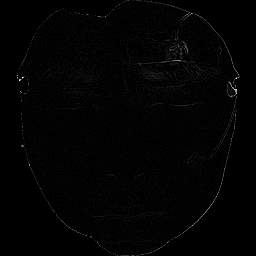

### 边缘检测

In [406]:
import cv2
import numpy as np

# 读取两张图片
img1 = cv2.imread(r'E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\pics_selected_cropped_optical\Micro\angry_wangshuai20230802_107_28.25_28.50_28.70\onset.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(r'E:\10.Doctoral materials\0.Micro-expression\1.PROJECTS\0.Multi-modality\pics_selected_cropped_optical\Micro\angry_wangshuai20230802_107_28.25_28.50_28.70\apex.png', cv2.IMREAD_GRAYSCALE)

# 计算帧差值
frame_diff = cv2.absdiff(img1, img2)

# 应用阈值处理
threshold_value = 30
_, thresh_frame_diff = cv2.threshold(frame_diff, threshold_value, 255, cv2.THRESH_BINARY)

# 显示结果
cv2.imshow('Threshold Frame Difference', thresh_frame_diff)
cv2.waitKey(0)
cv2.destroyAllWindows()

# 检查文件夹中图片的个数

In [87]:
import os

def count_files_in_folders(path):
    # 获取路径A下的所有文件和文件夹
    entries = os.listdir(path)
    
    # 遍历所有条目
    for entry in entries:
        entry_path = os.path.join(path, entry)
        
        # 检查当前条目是否为文件夹
        if os.path.isdir(entry_path):
            # 获取文件夹内的所有条目
            sub_entries = os.listdir(entry_path)
            # 计算文件数量
            file_count = sum(1 for sub_entry in sub_entries if os.path.isfile(os.path.join(entry_path, sub_entry)))
            
            if file_count < 6:
                print(f'文件夹 "{entry}" 中有 {file_count} 个文件')

# 示例调用
count_files_in_folders(r'5.pics_selected_segmented_cropped_align_opticalflow\Micro')

# 生成特征与标签

In [26]:
from torch.utils.data import TensorDataset, DataLoader
import torch
import matplotlib.pyplot as plt
from collections import Counter
from collections import OrderedDict
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import os
import pandas as pd
import cv2
import numpy as np

## 获取dataset

In [27]:
def get_dataset(opticalflow_path):
    dataset = {"X": [],  "y": [], "subject": []}

    for sample in os.listdir(opticalflow_path):
        label = sample.split('_')[0]
        subject = ''.join(filter(str.isalpha, sample.split('_')[1])) # 提取字符串中的字母部分，"liyan20230802"—>"liyan"

        of_path = os.path.join(opticalflow_path, sample, 'OF.png')
        os_path = os.path.join(opticalflow_path, sample, 'OS.png')
        horz_path = os.path.join(opticalflow_path, sample, 'H.png')
        vert_path = os.path.join(opticalflow_path, sample, 'V.png')

        dataset['X'].append((of_path, os_path, horz_path, vert_path))
        dataset['y'].append(label)
        dataset['subject'].append(subject)
    
    return dataset

In [28]:
# exp_type = 'Micro'
exp_type = 'Macro'
# exp_type = 'Ma+Mi'

label_map = {'angry': 0, 'surprise': 1, 'fear': 2, 'sad': 3, 'disgust': 4, 'tense': 5, 'happy': 6}
label_emotions = list(label_map.keys())
print('label_emotions:',label_emotions)

opticalflow_path = os.path.join('5.pics_selected_segmented_cropped_align_opticalflow', exp_type)

dataset_TAIIC = get_dataset(opticalflow_path)

label_emotions: ['angry', 'surprise', 'fear', 'sad', 'disgust', 'tense', 'happy']


In [29]:
# 统计每种情绪的频率
emotion_counts = Counter(dataset_TAIIC["y"])
# 将Counter对象转换为字典
counter_dict = dict(emotion_counts)
ordered_dict = dict(OrderedDict((key, counter_dict[key]) for key in label_emotions))
print('ordered_dict:', ordered_dict)

# 计算样本总数
total_sum = sum(ordered_dict.values())
print('total_sum:', total_sum)

ordered_dict: {'angry': 105, 'surprise': 26, 'fear': 67, 'sad': 62, 'disgust': 141, 'tense': 32, 'happy': 172}
total_sum: 605


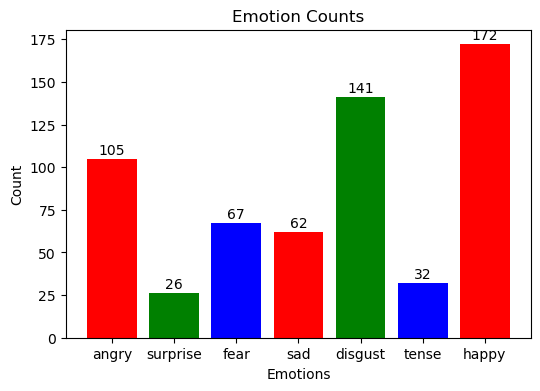

In [30]:
# 提取情绪标签及其数量
emotion_labels = list(ordered_dict.keys())
emotion_values = list(ordered_dict.values())

# 绘制柱状图
plt.figure(figsize=(6, 4))
bars = plt.bar(emotion_labels, emotion_values, color=['red', 'green', 'blue'])

# 在柱状图上显示数量
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Emotion Counts')
plt.show()

In [31]:
subjects_list = list(set(dataset_TAIIC['subject']))
print('subjects_list:', subjects_list)

subjects_list: ['zhangbuyuan', 'zhaolei', 'zhengwansheng', 'yangmi', 'yansen', 'zhangdi', 'fengdengfang', 'linjiaying', 'lizhuoru', 'liyan', 'wangxiaomin', 'wangziheng', 'zhaoshaohua', 'wangzishan', 'xietao', 'wangshuai']


## 网络模型

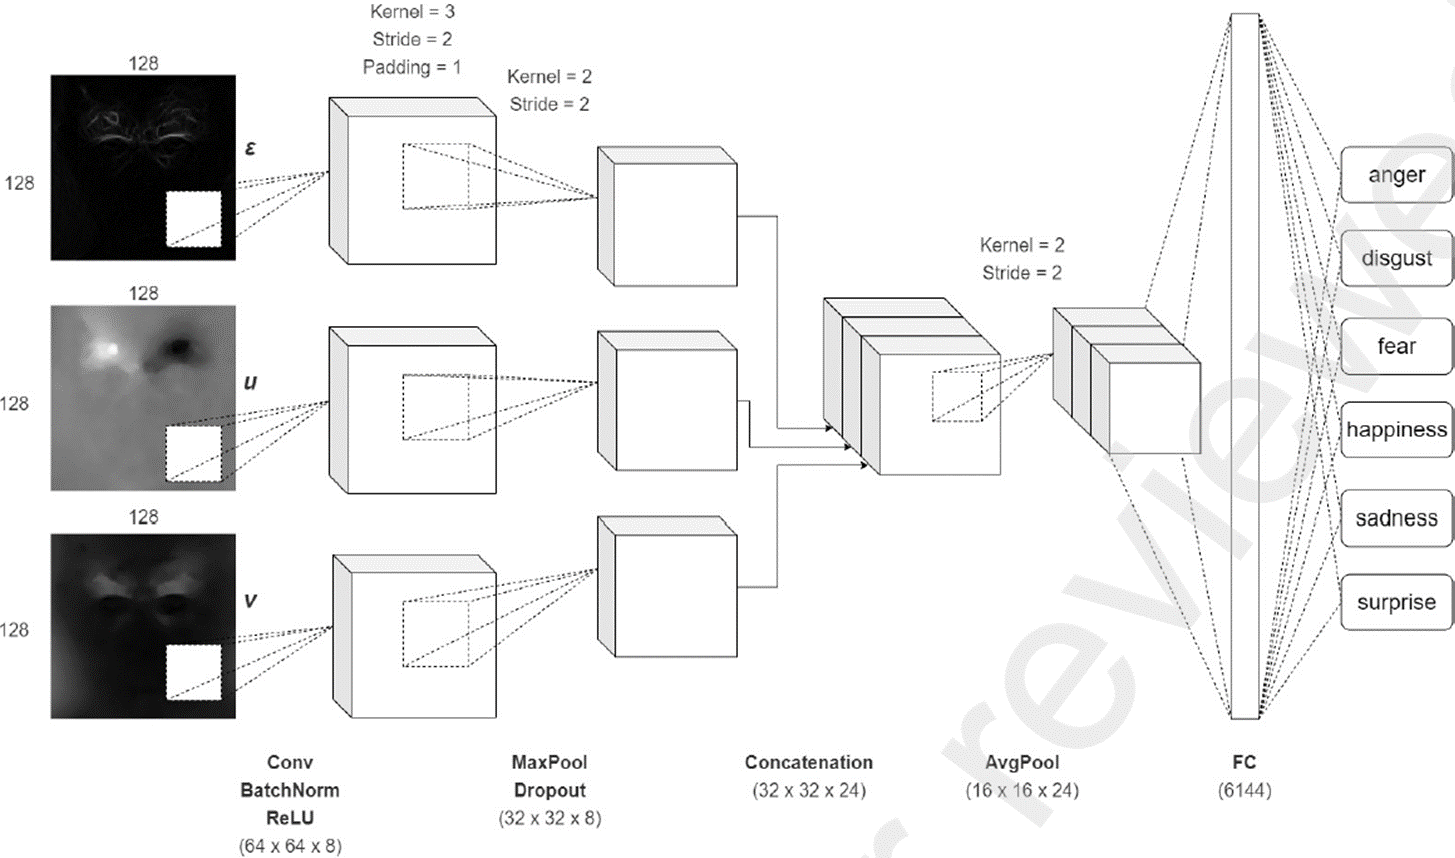

In [32]:
class MER(nn.Module):
    def __init__(self, in_channels=1, num_classes=7):
        super(MER, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels=8, kernel_size=3, stride=2, padding=1)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.batch_norm = nn.BatchNorm2d
        self.fc = nn.Linear(in_features=24576, out_features=num_classes)
        
        self.conv_layer1 = nn.Sequential(
            self.conv1, self.batch_norm(8), self.relu, self.max_pool, self.dropout
        )

        self.conv_layer2 = nn.Sequential(
            self.conv1, self.batch_norm(8), self.relu, self.max_pool, self.dropout
        )

        self.conv_layer3 = nn.Sequential(
            self.conv1, self.batch_norm(8), self.relu, self.max_pool, self.dropout
        )
    
    def forward(self, x):
        os, h, v = x
        x1 = self.conv_layer1(os)
        x2 = self.conv_layer2(h)
        x3 = self.conv_layer3(v)
        x = torch.cat((x1, x2, x3), dim=1)
        x = self.avg_pool(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [37]:
import torch
import torch.nn as nn
import torchvision.models as models

class MER_resnet18(nn.Module):
    def __init__(self, in_channels=1, num_classes=7):
        super(MER_resnet18, self).__init__()
        # 加载预训练的ResNet18模型
        resnet18 = models.resnet18(pretrained=True)
        
        self.features = resnet18
        # 移除最后一层以获取特征
        # self.features = torch.nn.Sequential(*list(resnet18.children())[:-1])
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(in_features=24576, out_features=num_classes)
        
    def forward(self, x):
        os, h, v = x
        print('os.shape:', os.shape) # os.shape: torch.Size([128, 1, 256, 256])
        img = np.array([os, h, v]).cpu()
        x = self.features(img)
#         x1 = self.features(os)
#         x2 = self.features(h)
#         x3 = self.features(v)
#         x = torch.cat((x1, x2, x3), dim=1)
        x = self.avg_pool(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

# 模型训练

In [14]:
def get_numerical_labels(emotion_list):
    label_map = {'angry': 0, 'surprise': 1, 'fear': 2, 'sad': 3, 'disgust': 4, 'tense': 5, 'happy': 6}
    # 使用列表推导式进行替换
    y_data_mapped = [label_map[emotion] for emotion in emotion_list]
    
    return y_data_mapped

In [15]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [16]:
def compute_f1_recall(real, pred):
    TN, FP, FN, TP = confusion_matrix(real, pred).ravel()
    if 2 * TP + FP + FN == 0:
        f1_score = 0
    else:
        f1_score = 2 * TP / (2 * TP + FP + FN)

    if real.count(1) == 0:
        recall = 0
    else:
        recall = TP / real.count(1)
    
    return f1_score, recall

In [17]:
def evaluation_metrics(real, pred, emotions):
    f1_list = []
    recall_list = []
    for i, emotion in enumerate(emotions):
        y_real = [1 if i == j else 0 for j in real]
        y_pred = [1 if i == j else 0 for j in pred]

        try:
            f1, recall = compute_f1_recall(y_real, y_pred)
            f1_list.append(f1)
            recall_list.append(recall)
        except Exception as e:
            print(e)
    
    uf1 = np.mean(f1_list)
    uar = np.mean(recall_list)

    return uf1, uar

In [18]:
def generate_dataloader(X, y, batch_size):
    X_data = []
    y_data = []

    g = torch.Generator() # 创建一个PyTorch的随机数生成器g
    g.manual_seed(0) # 将其种子设为0，以确保数据加载的可重复性

    # 遍历输入数据 X 和标签 y
    for (of, os, h, v), y in zip(X, y):
        # 以灰度模式读取图像文件
        of = cv2.imread(of, cv2.IMREAD_GRAYSCALE)
        os = cv2.imread(os, cv2.IMREAD_GRAYSCALE)
        h = cv2.imread(h, cv2.IMREAD_GRAYSCALE)
        v = cv2.imread(v, cv2.IMREAD_GRAYSCALE)

        # 将读取的三个图像 os、h 和 v 组合成一个 numpy 数组 img
        img = np.array([os, h, v])
        
        # 确保 img 的形状为 (3, 256, 256)
        if img.shape == (3, 256, 256):
            X_data.append(img)
            y_data.append(y)
        else:
            print(f"Unexpected image shape: {img.shape}")
    
    # 将 X_data 和 y_data 转换为 numpy 数组，然后进一步转换为 PyTorch 张量
    X_tensor = torch.Tensor(np.array(X_data))
    y_tensor = torch.Tensor(y_data).to(dtype=torch.long)

    # 使用 X_tensor 和 y_tensor 创建一个 TensorDataset，它是 PyTorch 数据集的一种类型
    tensor_dataset = TensorDataset(X_tensor, y_tensor)

    data_loader = DataLoader(tensor_dataset, 
                            batch_size=batch_size, # 在训练期间以指定的 batch_size 提供数据
                            shuffle=True, # shuffle=True 表示每个 epoch 之后打乱数据
                            num_workers=0, # num_workers=4 表示使用4个子进程来加载数据
                            worker_init_fn=seed_worker, # 设置数据加载的随机种子，以确保可重复性
                            generator=g)

    return data_loader

## 留一交叉验证

In [34]:
def generate_losocv_dataset(dataset, subject, out_dir, label_emotions, visualize=True):
    train_X = []
    train_y = []
    test_X = []
    test_y = []

    for x, y, s in zip(dataset['X'], dataset['y'], dataset['subject']):
        if subject == s:
            test_X.append(x)
            test_y.append(y)
        else:
            train_X.append(x)   
            train_y.append(y)

    if visualize:
        train_set = []
        test_set = []
        for i, emo in enumerate(label_emotions):
            train_set.append(train_y.count(emo))
            test_set.append(test_y.count(emo))

        df = pd.DataFrame({
            'train': train_set,
            'test': test_set
        }, index=label_emotions)

        fig, ax = plt.subplots(figsize=(6, 4))
        ax = df.plot.bar(rot=0, ax=ax)
        for container in ax.containers:
            ax.bar_label(container)

        ax.set_title('Data Distribution')
        plt.savefig(f"{out_dir}/data_distribution_{subject}.png")
        plt.show()
        plt.close(fig)
    
    # 将字符串的情绪类型转为数字
    train_y = get_numerical_labels(train_y)
    test_y = get_numerical_labels(test_y)
    
    return train_X, train_y, test_X, test_y

In [39]:
def train_locosv(epochs, lr, batch_size, out_dir, label_emotions):
    subjects = list(set(dataset_TAIIC['subject']))
    
    actual = []
    predicted = []
    uf1_history = []
    uar_history = []
    accuracy_history = []
    num_correct = 0
    total_sample = 0
    
    cm_df = None
    
    f = open('Train results/FULL_logs_loso.txt', 'a')
    
    
    for i, subject in enumerate(subjects):
    #     f.write(f'Subject ({i+1}/{len(subjects)}): {subject}\n')
        print(f'Subject ({i+1}/{len(subjects)}): {subject}')

        train_X, train_y, test_X, test_y = generate_losocv_dataset(dataset_TAIIC, subject, out_dir, label_emotions)
        train_loader = generate_dataloader(train_X, train_y, batch_size=batch_size)
        test_loader = generate_dataloader(test_X, test_y, batch_size=batch_size)
        
        model = MER().to(device)
#         model = MER_resnet18().to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        
        # TRAINING
        model.train()
        
        for epoch in range(epochs):
            for batch, y in train_loader:
                batch = batch.to(device)
                y = y.to(device)

                os = batch[:, :1, :, :]
                h = batch[:, 1:2, :, :]
                v = batch[:, 2:, :, :]

                optimizer.zero_grad()
                y_hat = model.forward((os, h, v))
                loss = criterion(y_hat, y)

                loss.backward()
                optimizer.step()
                
        # TESTING
        model.eval()
        with torch.no_grad():
            y_preds = torch.Tensor().to(device)
            y_test = torch.Tensor().to(device)

            for batch, y in test_loader:
                batch = batch.to(device)
                y = y.to(device)

                os = batch[:, :1, :, :]
                h = batch[:, 1:2, :, :]
                v = batch[:, 2:, :, :]

                y_hat = model.forward((os, h, v))
                y_hat = torch.argmax(y_hat, dim=1)
                y_preds = torch.cat((y_preds, y_hat), dim=0)
                y_test = torch.cat((y_test, y), dim=0)
            
            y_test = y_test.to('cpu')
            y_preds = y_preds.to('cpu')
            f.write(f'Ground Truth:\t{[int(i) for i in y_test.tolist()]}\n')
            f.write(f'Predicted:\t{[int(i) for i in y_preds.tolist()]}\n')
            print(f'Ground Truth:\t{[int(i) for i in y_test.tolist()]}')
            print(f'Predicted:\t{[int(i) for i in y_preds.tolist()]}')
            
            cm = confusion_matrix(y_test, y_preds, labels=range(7))
            if type(cm_df) != pd.DataFrame:
                cm_df = pd.DataFrame(cm, index=label_emotions, columns=label_emotions)
            else:
                cm_df = cm_df.add(pd.DataFrame(cm, index=label_emotions, columns=label_emotions))
            
            num_correct += (y_preds == y_test).sum().item()
            total_sample += len(y_test)
            accuracy = num_correct / total_sample
            accuracy_history.append(accuracy)

            actual.extend(y_test.tolist())
            predicted.extend(y_preds.tolist())

            uf1, uar = evaluation_metrics(actual, predicted, label_emotions)
            uf1_history.append(uf1)
            uar_history.append(uar)

            f.write(f'[OVERALL] Accuracy: {accuracy:.4f} | UF1 score: {uf1:.4f} | UAR score: {uar:.4f}\n')
            f.write('=========================================================\n')
            print(f'[OVERALL] Accuracy: {accuracy:.4f} | UF1 score: {uf1:.4f} | UAR score: {uar:.4f}')
            print('=========================================================')

In [ ]:
epoch = 200
lr = 0.001
batch_size = 128
out_dir = r'Data Distribution\Data Distribution loso'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

train_locosv(epoch, lr, batch_size, out_dir, label_emotions)

## 10折交叉验证

In [26]:
from sklearn.model_selection import KFold

def train_10foldcv(epochs, lr, batch_size, out_dir, label_emotions):
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)  # 创建10折交叉验证的实例
    subjects = list(set(dataset_TAIIC['subject']))
    dataset_indices = list(range(len(dataset_TAIIC['subject'])))  # 获取数据集索引列表

    # 用于保存所有折的评估结果
    actual = []
    predicted = []
    uf1_history = []
    uar_history = []
    accuracy_history = []
    num_correct = 0
    total_sample = 0
    cm_df = None
    
    f = open('Train results/FULL_logs_10fold.txt', 'a')

    for fold, (train_indices, test_indices) in enumerate(kfold.split(dataset_indices)):
        print(f'Fold {fold + 1}/{10}')

        # 根据索引分割训练集和测试集
        train_X = [dataset_TAIIC['X'][i] for i in train_indices]
        train_y = [dataset_TAIIC['y'][i] for i in train_indices]
        test_X = [dataset_TAIIC['X'][i] for i in test_indices]
        test_y = [dataset_TAIIC['y'][i] for i in test_indices]
        
        # 将字符串的情绪类型转为数字
        train_y = get_numerical_labels(train_y)
        test_y = get_numerical_labels(test_y)

        train_loader = generate_dataloader(train_X, train_y, batch_size=batch_size)
        test_loader = generate_dataloader(test_X, test_y, batch_size=batch_size)

        model = MER().to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        
        # TRAINING
        model.train()
        
        for epoch in range(epochs):
            for batch, y in train_loader:
                batch = batch.to(device)
                y = y.to(device)

                os = batch[:, :1, :, :]
                h = batch[:, 1:2, :, :]
                v = batch[:, 2:, :, :]

                optimizer.zero_grad()
                y_hat = model.forward((os, h, v))
                loss = criterion(y_hat, y)

                loss.backward()
                optimizer.step()
                
        # TESTING
        model.eval()
        with torch.no_grad():
            y_preds = torch.Tensor().to(device)
            y_test = torch.Tensor().to(device)

            for batch, y in test_loader:
                batch = batch.to(device)
                y = y.to(device)

                os = batch[:, :1, :, :]
                h = batch[:, 1:2, :, :]
                v = batch[:, 2:, :, :]

                y_hat = model.forward((os, h, v))
                y_hat = torch.argmax(y_hat, dim=1)
                y_preds = torch.cat((y_preds, y_hat), dim=0)
                y_test = torch.cat((y_test, y), dim=0)
            
            y_test = y_test.to('cpu')
            y_preds = y_preds.to('cpu')
            f.write(f'Ground Truth:\t{[int(i) for i in y_test.tolist()]}\n')
            f.write(f'Predicted:\t{[int(i) for i in y_preds.tolist()]}\n')
            print(f'Ground Truth:\t{[int(i) for i in y_test.tolist()]}')
            print(f'Predicted:\t{[int(i) for i in y_preds.tolist()]}')
            
            cm = confusion_matrix(y_test, y_preds, labels=range(7))
            if type(cm_df) != pd.DataFrame:
                cm_df = pd.DataFrame(cm, index=label_emotions, columns=label_emotions)
            else:
                cm_df = cm_df.add(pd.DataFrame(cm, index=label_emotions, columns=label_emotions))
            
            num_correct += (y_preds == y_test).sum().item()
            total_sample += len(y_test)
            accuracy = num_correct / total_sample
            accuracy_history.append(accuracy)

            actual.extend(y_test.tolist())
            predicted.extend(y_preds.tolist())

            uf1, uar = evaluation_metrics(actual, predicted, label_emotions)
            uf1_history.append(uf1)
            uar_history.append(uar)

            f.write(f'[OVERALL] Accuracy: {accuracy:.4f} | UF1 score: {uf1:.4f} | UAR score: {uar:.4f}\n')
            f.write('=========================================================\n')
            print(f'[OVERALL] Accuracy: {accuracy:.4f} | UF1 score: {uf1:.4f} | UAR score: {uar:.4f}')
            print('=========================================================')

In [34]:
epoch = 200
lr = 0.001
batch_size = 64
out_dir = r'Data Distribution\Data Distribution kfold'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_10foldcv(epoch, lr, batch_size, out_dir, label_emotions)

Fold 1/10
Ground Truth:	[2, 0, 5, 6, 3, 6, 4, 4, 4, 5, 6, 0, 2, 4, 2, 1, 2, 0, 4, 6, 4, 6, 5, 4, 3, 4, 5, 6, 0, 3, 4, 0, 4, 5, 4, 4, 0, 0, 6, 0, 0, 4, 6, 3, 6, 6, 3, 1, 3, 5, 0, 0, 6, 6, 4, 0, 6, 3, 4, 2, 5]
Predicted:	[2, 4, 0, 6, 3, 6, 4, 4, 4, 1, 0, 0, 5, 0, 6, 0, 2, 0, 2, 6, 4, 6, 6, 4, 4, 4, 5, 6, 4, 3, 4, 4, 4, 5, 4, 4, 0, 0, 6, 0, 4, 4, 6, 3, 6, 6, 3, 1, 3, 2, 4, 4, 6, 6, 4, 0, 6, 3, 4, 5, 2]
[OVERALL] Accuracy: 0.6885 | UF1 score: 0.6234 | UAR score: 0.6189
Fold 2/10
Ground Truth:	[2, 0, 5, 2, 6, 2, 4, 4, 4, 5, 6, 0, 2, 4, 2, 3, 2, 0, 4, 6, 4, 2, 1, 4, 6, 4, 3, 6, 0, 6, 4, 0, 4, 1, 4, 4, 0, 0, 2, 0, 0, 0, 6, 6, 6, 2, 6, 3, 6, 3, 0, 0, 2, 2, 4, 0, 2, 6, 4, 2, 1]
Predicted:	[0, 3, 3, 4, 4, 2, 6, 4, 4, 1, 6, 0, 2, 4, 2, 0, 2, 6, 4, 6, 4, 4, 0, 4, 6, 0, 4, 0, 4, 4, 4, 0, 4, 1, 4, 4, 0, 0, 6, 0, 0, 0, 6, 6, 0, 6, 6, 0, 6, 3, 0, 4, 2, 2, 4, 5, 4, 6, 5, 6, 1]
[OVERALL] Accuracy: 0.6393 | UF1 score: 0.5934 | UAR score: 0.5844
Fold 3/10
Ground Truth:	[2, 0, 5, 6, 6, 6, 4, 4, 4, 5, 6, 0,